In [2]:

import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

import anndata
import scanpy as sc

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [4]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [5]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [15]:
#Select for hvgs
adata = sc.read_loom('/home/tchari/counts/monod_liver/loom/liver_c72_sc.loom') #sc


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
adata

AnnData object with n_obs × n_vars = 11219 × 36601
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [17]:
meta = pd.read_csv('/home/tchari/metadata/liver_GSE185477_Final_Metadata.txt',sep='\t')
meta.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,cell_barcode,donor,cell_ID,S.Score,G2M.Score,Phase,sample,assay_type,Coarse_clusters,Manual_Annotation,Subcluster_Group,sub_cluster,sub_annotation,UMAP1,UMAP2
C41_AAACCTGAGCCTTGAT,C41,428,199,32.087912,AAACCTGAGCCTTGAT,C41,C41_AAACCTGAGCCTTGAT,-0.009246,-0.016106,G1,C41,single_cell,11,InterHep,Hepatocyte,Hep_6,Hep_Unidentified,-3.321926,-6.397605
C41_AAACCTGAGGTCATCT,C41,275,181,19.666667,AAACCTGAGGTCATCT,C41,C41_AAACCTGAGGTCATCT,-0.018254,-0.027253,G1,C41,single_cell,10,cvLSECs,LSECs,LSEC_1,LSEC_Central Venous LSEC,14.034962,2.834506
C41_AAACCTGAGTCGCCGT,C41,632,264,15.703704,AAACCTGAGTCGCCGT,C41,C41_AAACCTGAGTCGCCGT,-0.010180,-0.027701,G1,C41,single_cell,13,Bcells,Bcells,Lymph_5,Lymph_Mature B cells,-1.928654,-7.027950
C41_AAACCTGAGTGGAGTC,C41,10508,1923,12.188988,AAACCTGAGTGGAGTC,C41,C41_AAACCTGAGTGGAGTC,0.030654,-0.030400,S,C41,single_cell,4,InterHep,Hepatocyte,Hep_4,Hep_PP2,1.582531,3.822350
C41_AAACCTGAGTTAACGA,C41,503,220,26.355140,AAACCTGAGTTAACGA,C41,C41_AAACCTGAGTTAACGA,-0.020764,-0.021055,G1,C41,single_cell,7,NKTcell,NKTcell,Lymph_0,Lymph_ab T cells,-2.318836,-13.029733


In [18]:
np.unique(meta['sample'])

array(['C41', 'C41_CST', 'C41_NST', 'C41_TST', 'C58_RESEQ', 'C58_TST',
       'C70_RESEQ', 'C70_TST', 'C72_RESEQ', 'C72_TST'], dtype=object)

In [19]:
donor = 'C72_RESEQ' # C72_TST
meta_sub = meta[(meta['sample']==donor) & (~meta['sub_annotation'].isin(['Doublet/Contamination']))]
print(np.unique(meta_sub['assay_type']))
meta_sub.head()

['single_cell']


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,cell_barcode,donor,cell_ID,S.Score,G2M.Score,Phase,sample,assay_type,Coarse_clusters,Manual_Annotation,Subcluster_Group,sub_cluster,sub_annotation,UMAP1,UMAP2
C72_RESEQ_AAACCTGAGATAGCAT,C72_RESEQ,3969,1284,9.536266,AAACCTGAGATAGCAT,C72,C72_RESEQ_AAACCTGAGATAGCAT,0.031886,0.000759,S,C72_RESEQ,single_cell,4,InterHep,Hepatocyte,Hep_9,Hep_PP2,2.804319,3.169094
C72_RESEQ_AAACCTGAGATCCCGC,C72_RESEQ,1166,572,14.907333,AAACCTGAGATCCCGC,C72,C72_RESEQ_AAACCTGAGATCCCGC,-0.020776,-0.016762,G1,C72_RESEQ,single_cell,0,PortalHep,Hepatocyte,Hep_6,Hep_Unidentified,-0.475485,5.967654
C72_RESEQ_AAACCTGAGCCCAATT,C72_RESEQ,1748,747,19.115324,AAACCTGAGCCCAATT,C72,C72_RESEQ_AAACCTGAGCCCAATT,0.030117,0.006298,S,C72_RESEQ,single_cell,7,NKTcell,NKTcell,Lymph_3,Lymph_gd T cells,-3.278690,-13.595572
C72_RESEQ_AAACCTGAGTAACCCT,C72_RESEQ,744,402,16.267339,AAACCTGAGTAACCCT,C72,C72_RESEQ_AAACCTGAGTAACCCT,-0.018051,-0.026479,G1,C72_RESEQ,single_cell,10,cvLSECs,LSECs,LSEC_0,LSEC_Central Venous LSEC,13.562950,2.180273
C72_RESEQ_AAACCTGAGTCATCCA,C72_RESEQ,695,392,17.857143,AAACCTGAGTCATCCA,C72,C72_RESEQ_AAACCTGAGTCATCCA,0.057112,-0.016705,S,C72_RESEQ,single_cell,11,InterHep,Hepatocyte,Hep_1,Hep_IZ1,-3.144158,-4.495046


In [20]:
meta_sub['Subcluster_Group'].value_counts() #Filter out doublets

Hepatocyte       7348
LSECs             967
Cholangiocyte     331
NKTcell           302
Stellate          248
Bcells             16
Name: Subcluster_Group, dtype: int64

In [21]:
np.unique(meta_sub['Phase'])

array(['G1', 'G2M', 'S'], dtype=object)

**Make final metadata and count/loom file for subsetted cells**

In [22]:
tokeep = list(meta_sub['Subcluster_Group'].value_counts().index[meta_sub['Subcluster_Group'].value_counts() > 100])
tokeep

['Hepatocyte', 'LSECs', 'Cholangiocyte', 'NKTcell', 'Stellate']

In [23]:
tokeep = ['LSECs', 'Stellate', 'NKTcell', 'Cholangiocyte']

In [24]:
meta_sub = meta_sub[meta_sub['Subcluster_Group'].isin(tokeep)]
meta_sub.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,cell_barcode,donor,cell_ID,S.Score,G2M.Score,Phase,sample,assay_type,Coarse_clusters,Manual_Annotation,Subcluster_Group,sub_cluster,sub_annotation,UMAP1,UMAP2
C72_RESEQ_AAACCTGAGCCCAATT,C72_RESEQ,1748,747,19.115324,AAACCTGAGCCCAATT,C72,C72_RESEQ_AAACCTGAGCCCAATT,0.030117,0.006298,S,C72_RESEQ,single_cell,7,NKTcell,NKTcell,Lymph_3,Lymph_gd T cells,-3.278690,-13.595572
C72_RESEQ_AAACCTGAGTAACCCT,C72_RESEQ,744,402,16.267339,AAACCTGAGTAACCCT,C72,C72_RESEQ_AAACCTGAGTAACCCT,-0.018051,-0.026479,G1,C72_RESEQ,single_cell,10,cvLSECs,LSECs,LSEC_0,LSEC_Central Venous LSEC,13.562950,2.180273
C72_RESEQ_AAACCTGTCTTACCGC,C72_RESEQ,770,431,13.882064,AAACCTGTCTTACCGC,C72,C72_RESEQ_AAACCTGTCTTACCGC,-0.009755,-0.029853,G1,C72_RESEQ,single_cell,18,PortalEndo,LSECs,LSEC_2,LSEC_Periportal LSEC,11.643445,0.238182
C72_RESEQ_AAACGGGCATCATCCC,C72_RESEQ,1014,532,16.772439,AAACGGGCATCATCCC,C72,C72_RESEQ_AAACGGGCATCATCCC,0.041117,0.027931,S,C72_RESEQ,single_cell,18,PortalEndo,LSECs,LSEC_2,LSEC_Periportal LSEC,11.185063,-0.404773
C72_RESEQ_AAACGGGCATCTCGCT,C72_RESEQ,1396,767,10.297030,AAACGGGCATCTCGCT,C72,C72_RESEQ_AAACGGGCATCTCGCT,0.024817,-0.016359,S,C72_RESEQ,single_cell,12,Stellate,Stellate,Stellate_0,Stellate_HSC1,6.980232,-1.099799


In [25]:
bars = list(meta_sub.cell_barcode)
adata_sub = adata[adata.obs['barcode'].isin(bars)]
adata_sub

View of AnnData object with n_obs × n_vars = 1848 × 36601
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [26]:
sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)
sc.pp.highly_variable_genes(adata_sub, n_top_genes=2000, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset to highly variable genes
adata_hvg = adata_sub[:, adata_sub.var.highly_variable]

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [27]:
adata_hvg

View of AnnData object with n_obs × n_vars = 1848 × 1999
    obs: 'barcode'
    var: 'gene_id', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'matrix', 'spliced', 'unspliced'

In [28]:
#adata_hvg = adata_sub
adata_hvg.layers['spliced'].shape

(1848, 1999)

In [29]:
#Save adata_hvg to loom
allS = adata_hvg.layers['spliced']
allU = adata_hvg.layers['unspliced']
retAdata = anndata.AnnData(
			X=allS,
			layers={
				'spliced': allS,
				'unspliced': allU
			},
			obs=pd.DataFrame({'barcode': np.array(adata_hvg.obs['barcode'])},index=np.array(adata_hvg.obs['barcode'])),
			var=pd.DataFrame({'gene_name': np.array(adata_hvg.var['gene_name'])},index=np.array(adata_hvg.var['gene_name']))
		)

retAdata.write_loom('/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom')

In [30]:
ds = lp.connect('/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom')


In [31]:
ds.layers['spliced'][:,:].shape

(1999, 1848)

In [32]:
ds.close()

## **Initialize Data for Inference**

In [34]:
chosen = [tokeep,tokeep] #[['L5_IT','L2-3_IT','L6_IT'],['L6_CT','L2-3_IT','L6_IT']] 
individs = []
for names in chosen:
    individs += [[i] for i in names]

In [35]:
num_ks = 3
ks = [1,4,10,1,4,10]

In [36]:
dataset_meta = ['hvg_liver_c72_sn']
print('dataset_meta: ', dataset_meta)
print()



#DUSP9_MAPK1__DUSP9_MAPK1 may have 'multiple transcriptional states'
subcluster_names = []
for r in range(len(chosen)):
    subcluster_names += [chosen[r]]*num_ks

subcluster_names += individs

sub_names_only = ['_'.join(n) for n in subcluster_names]
for i in range(len(ks)):
    sub_names_only[i] = sub_names_only[i]+'_k'+str(ks[i])
    
cluster_names = []
dataset_names = [dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/monod_liver/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['hvg_liver_c72_sn']

dataset_names:  ['hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k1', 'hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k4', 'hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k10', 'hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k1', 'hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k4', 'hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k10', 'hvg_liver_c72_sn_LSECs', 'hvg_liver_c72_sn_Stellate', 'hvg_liver_c72_sn_NKTcell', 'hvg_liver_c72_sn_Cholangiocyte', 'hvg_liver_c72_sn_LSECs', 'hvg_liver_c72_sn_Stellate', 'hvg_liver_c72_sn_NKTcell', 'hvg_liver_c72_sn_Cholangiocyte']
len(dataset_names):  14

loom_filepaths:  ['/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom', '/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom', '/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom', '/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom', '/home/tchari/counts/monod_liver/loom/hvg_liver_c72_sn.loom

Dataset hvg_liver_c72_sn. 
	1848 barcodes in loom, 1802 pass filter. AAACCTGAGCCCAATTAAACCTGAGTAACCCTAAACCTGTCTTACCGCAAACGGGCATCATCCCAAACGGGCATCTCGCTAAACGGGTCAGCGATTAAAGATGAGCTGAACGAAAGATGGTATATCCGAAAGATGTCAGCTCGGAAAGCAAAGCCTATGTAAAGCAATCACCGTAAAAAGTAGGTCTCGTTCAAAGTAGGTTTGTTGGAAATGCCCAGCGATCCAAATGCCGTCTTGCGGAACACGTAGCCCAATTAACACGTAGGTCGGATAACACGTAGGTGTTAAAACACGTCACAGAGGTAACACGTCAGACGCTCAACACGTGTGAGTATAAACACGTTCCAGAAGGAACACGTTCCGTACAAAACCATGAGGAGCGAGAACCATGAGGCAGGTTAACCATGGTCGCGAAAAACCATGGTTCTGAACAACCGCGAGCTTATCGAACCGCGAGGTACTCTAACCGCGAGTCACGCCAACCGCGCATTGGTACAACCGCGGTGTTAAGAAACCGCGTCGCCCTTAAACCGCGTCTAAGCCAAACGTTGCAACAACCTAACGTTGCAAGCCTATAACGTTGCATGGTCTAAACGTTGGTGTCGCTGAACGTTGTCGATGAGGAACGTTGTCGCTAGCGAACTCAGAGAACTGTAAACTCAGAGCCAGAACAACTCAGAGCCGGTAAAACTCAGGTACTTGACAACTCAGGTCGAGATGAACTCCCAGTGTTGAAAACTCCCTCCTGCAGGAACTCCCTCGCTAGCGAACTCTTAGGAGTCTGAACTCTTCAAGTACCTAACTCTTCACTGCCAGAACTCTTCATCTACGAAACTCTTTCTTGACGAAACTGGTAGACTGGGTAACTGGTCAAGCGTAGAACTTTCCAAAGGCGTAACTTTCGTGATGATAAACTTTCTCTGCCCTAAAG

	['LSECs', 'Stellate', 'NKTcell', 'Cholangiocyte']: 1848 cells in annotations. 1848 in loom. 1802 pass filter.
	['LSECs', 'Stellate', 'NKTcell', 'Cholangiocyte']: 1848 cells in annotations. 1848 in loom. 1802 pass filter.
	['LSECs', 'Stellate', 'NKTcell', 'Cholangiocyte']: 1848 cells in annotations. 1848 in loom. 1802 pass filter.
	['LSECs', 'Stellate', 'NKTcell', 'Cholangiocyte']: 1848 cells in annotations. 1848 in loom. 1802 pass filter.
	['LSECs', 'Stellate', 'NKTcell', 'Cholangiocyte']: 1848 cells in annotations. 1848 in loom. 1802 pass filter.
	['LSECs']: 967 cells in annotations. 967 in loom. 922 pass filter.
	['Stellate']: 248 cells in annotations. 248 in loom. 247 pass filter.
	['NKTcell']: 302 cells in annotations. 302 in loom. 302 pass filter.
	['Cholangiocyte']: 331 cells in annotations. 331 in loom. 331 pass filter.
	['LSECs']: 967 cells in annotations. 967 in loom. 922 pass filter.
	['Stellate']: 248 cells in annotations. 248 in loom. 247 pass filter.
	['NKTcell']: 302 cel

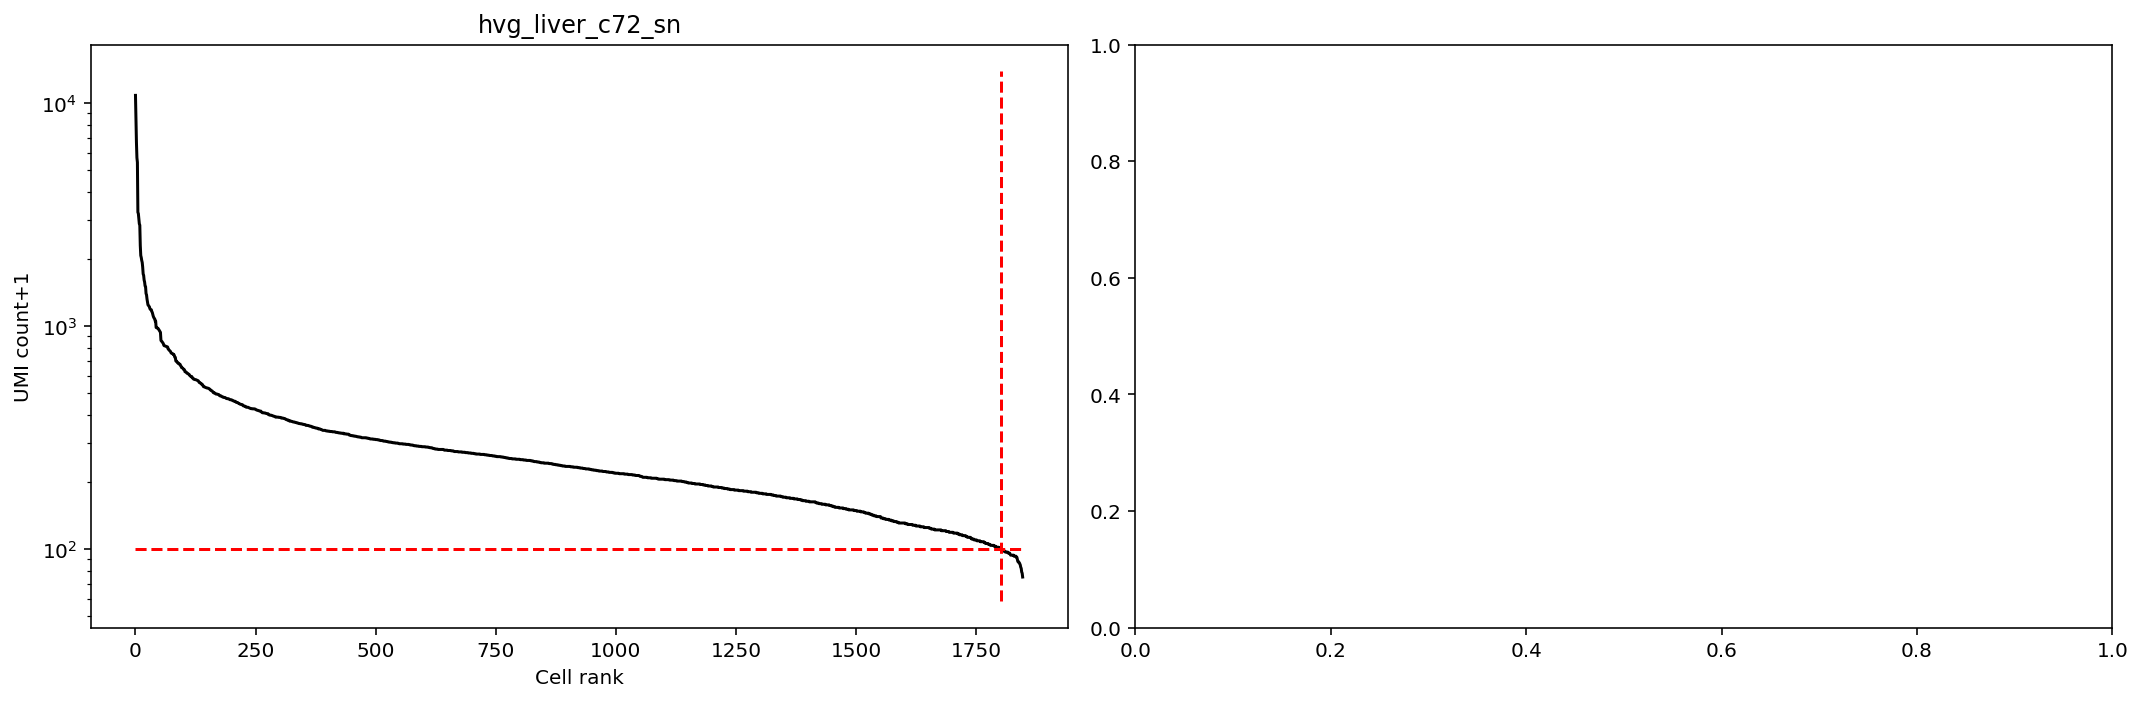

In [37]:
cf = []

#thr_ub = [5e4]*len(dataset_meta)*2
thr_lb = [100]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k]
    dataset_name = raw_data_locations[len(subcluster_names)*k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k]) #& ((S+U).sum(0)<thr_ub[k])
        
        n_annot_bcs = meta_sub['cell_barcode'].sum()
        annot_bcs_in_loom = meta_sub['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta_sub['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in subcluster_names:
            annot_bcs = meta_sub[(meta_sub['Subcluster_Group'].isin(subcluster))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_top_liver_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [38]:
all_assigns = [list(meta_sub['Manual_Annotation'][meta_sub['cell_barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns))

1802


In [39]:
all_assigns2 = [list(meta_sub['Manual_Annotation'][meta_sub['cell_barcode'] == i])[0] for i in bcs[cf[3]]]
print(len(all_assigns2))

1802


In [40]:
assigns = [all_assigns]*num_ks + [all_assigns2]*num_ks

In [41]:
np.unique(all_assigns)

array(['Cholangiocyte', 'NKTcell', 'PortalEndo', 'Stellate', 'cvLSECs'],
      dtype='<U13')

## **Gene Filtering**

In [42]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1 already exists.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k1
INFO:root:1802 cells detected.
INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:161 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k1 created.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k4
INFO:root:1802 cells detected.
INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:161 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k4 created.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k10
INFO:root:1802 cells detected.
INFO:root:1999 features observed, 1976 match g

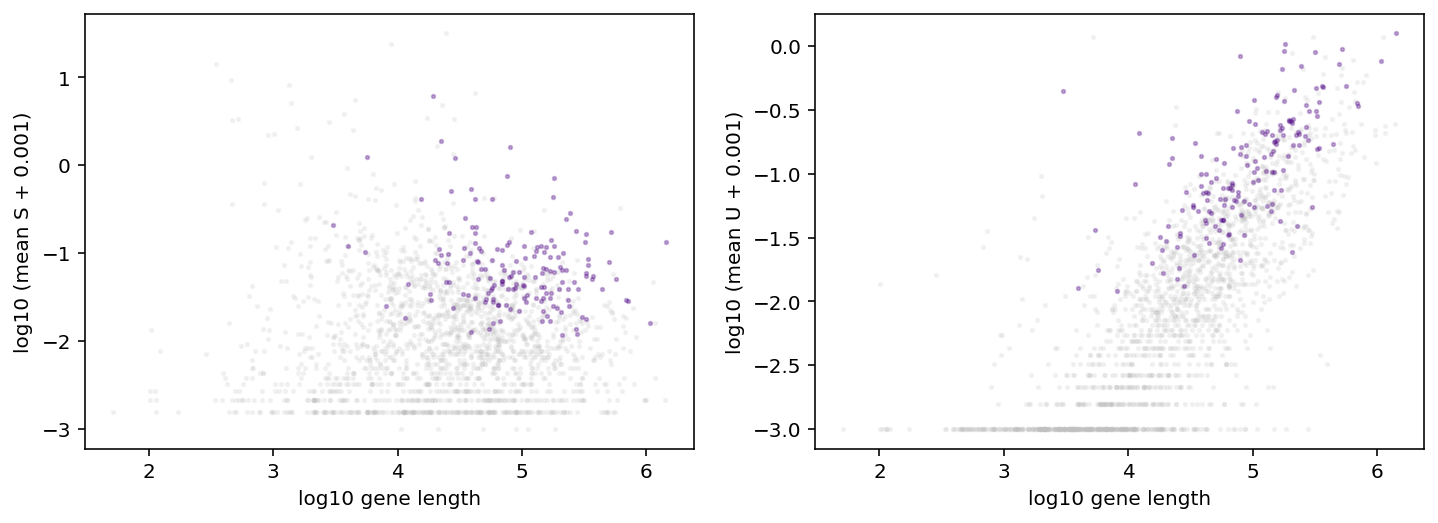

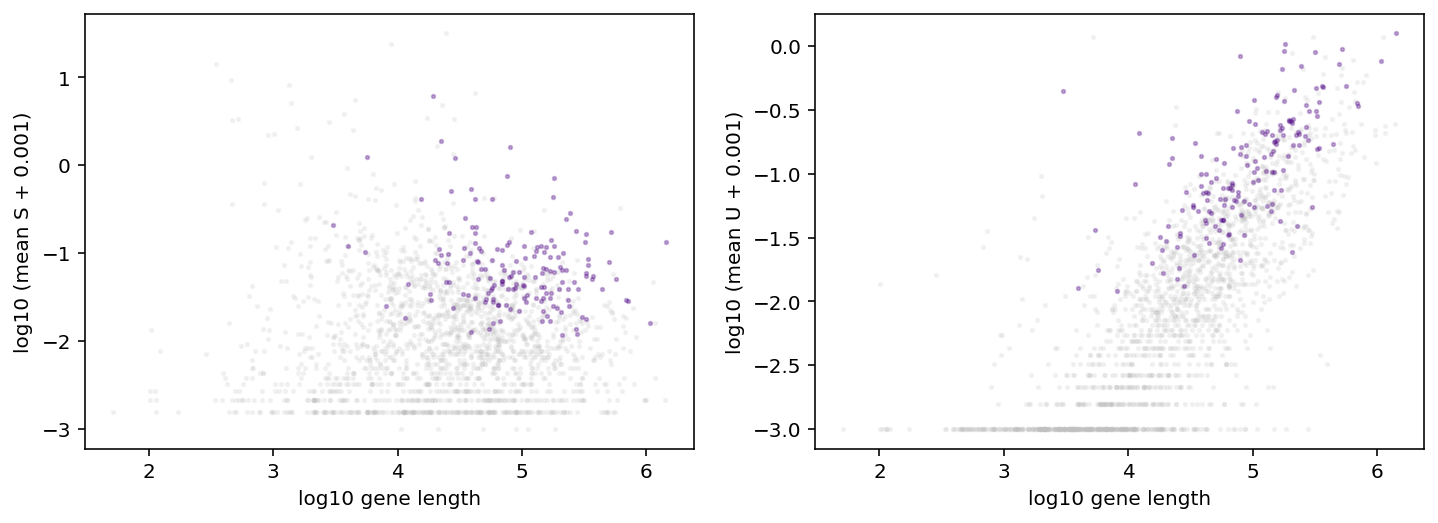

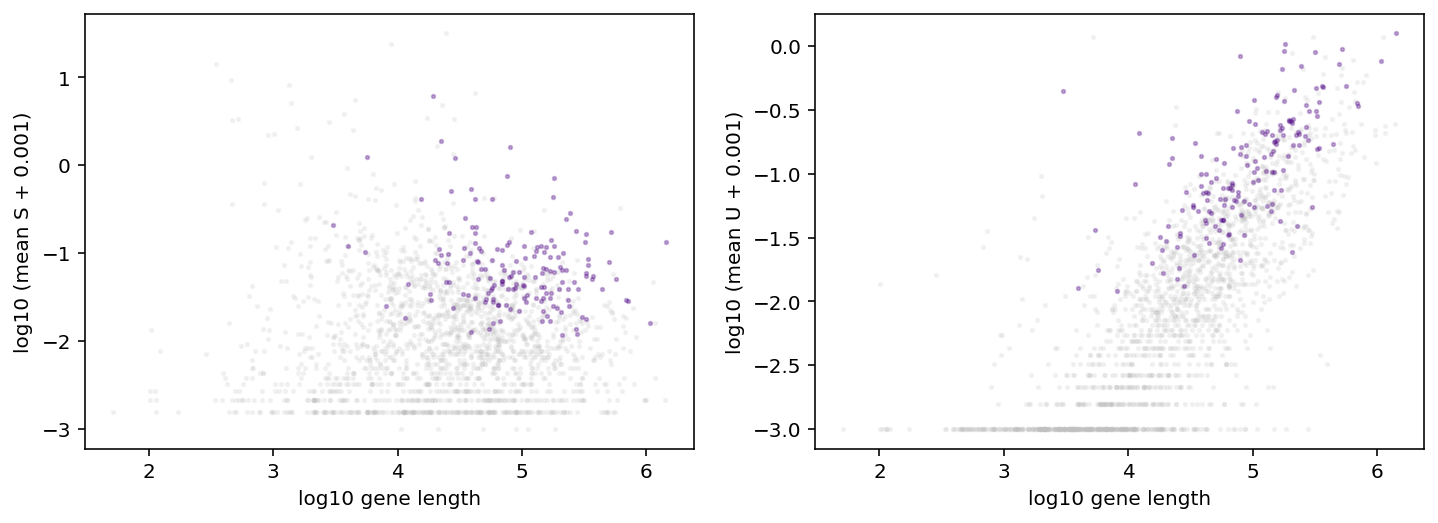

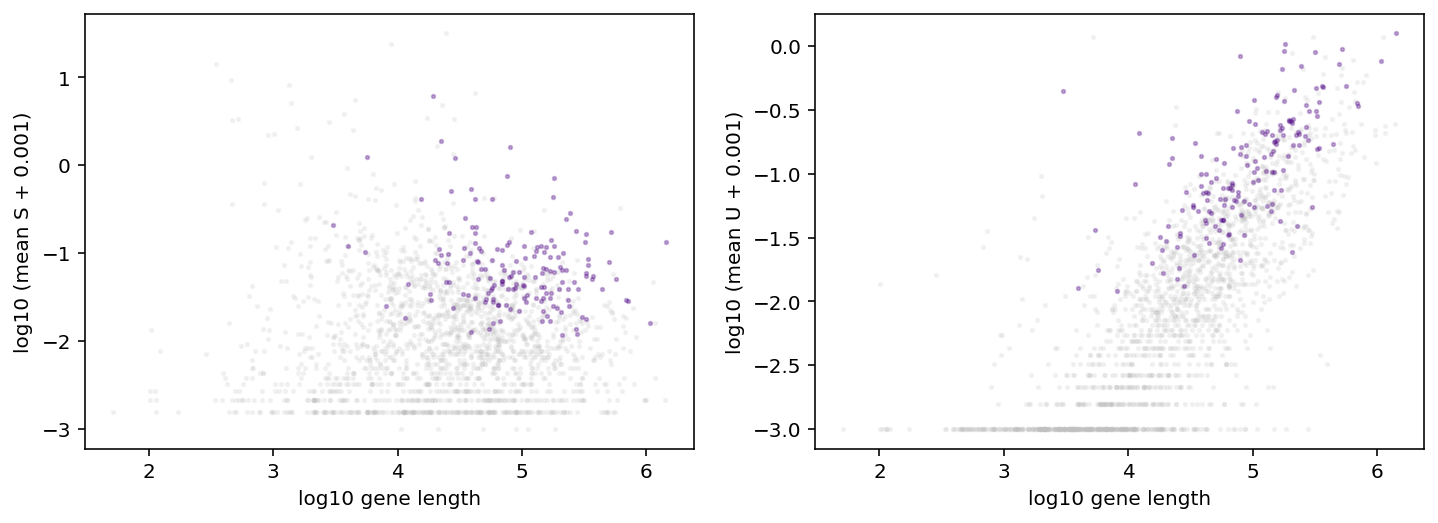

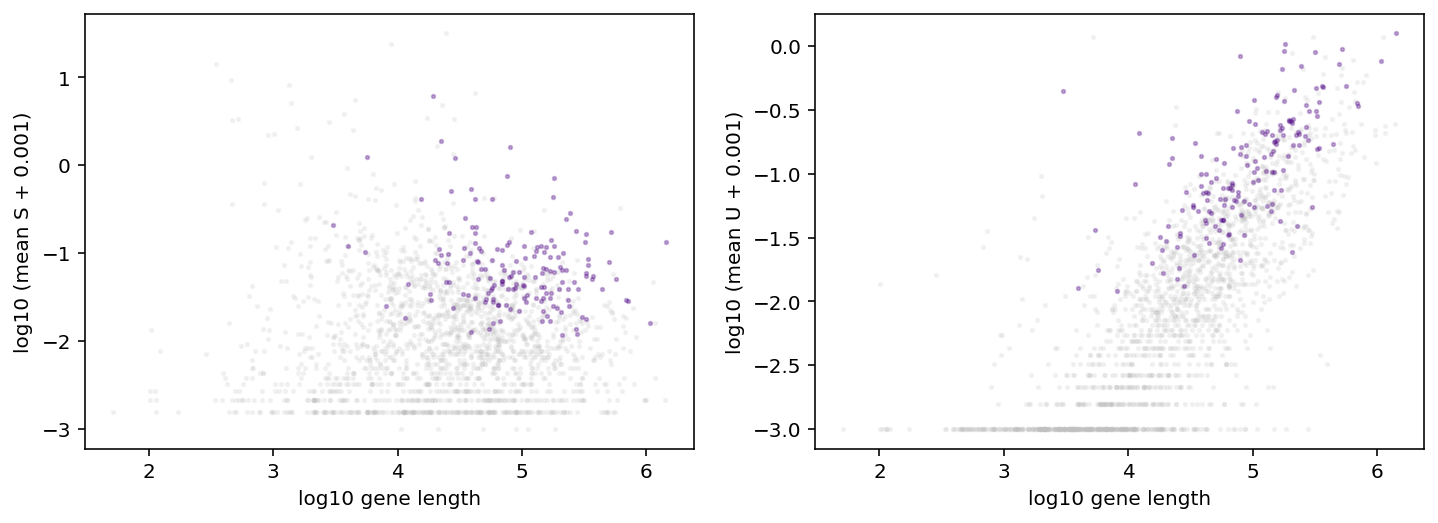

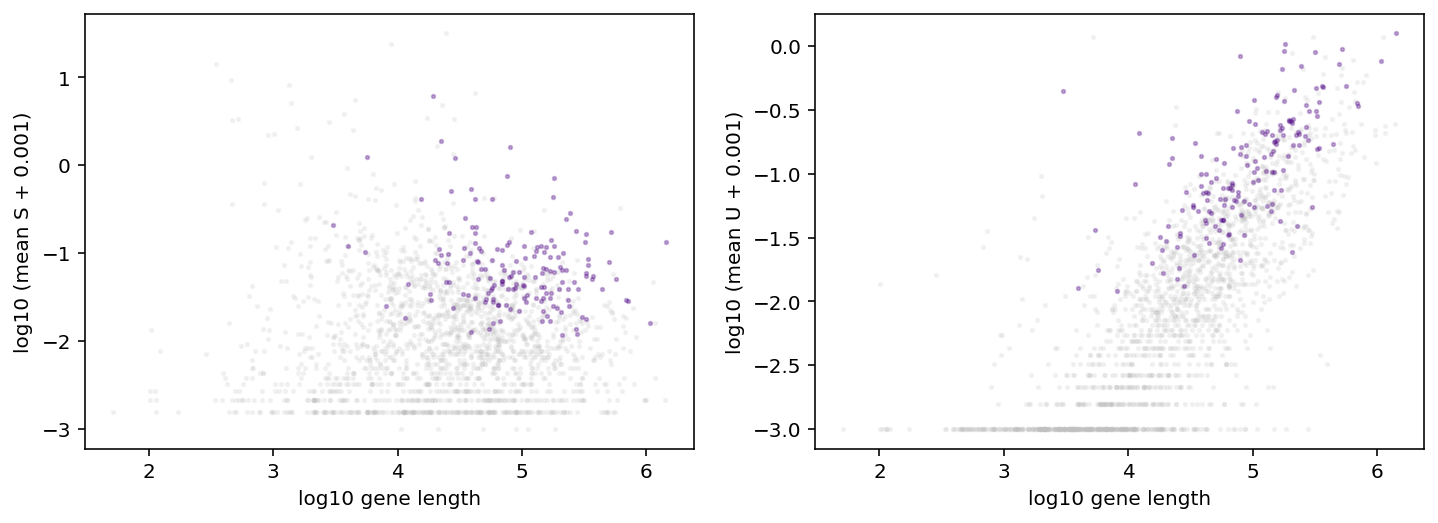

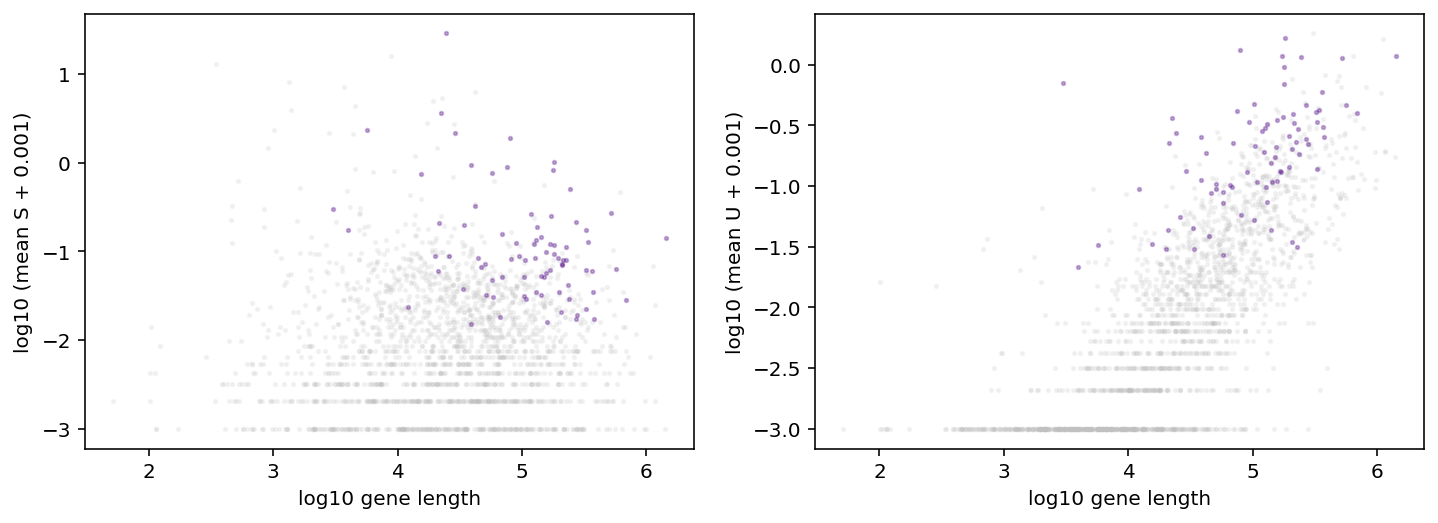

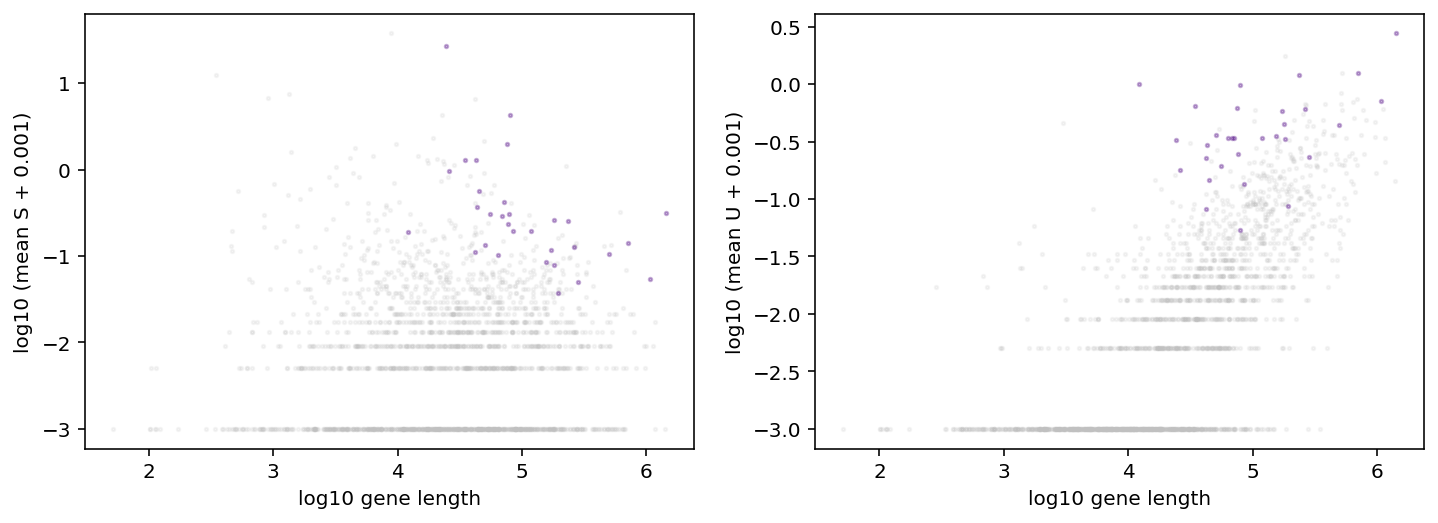

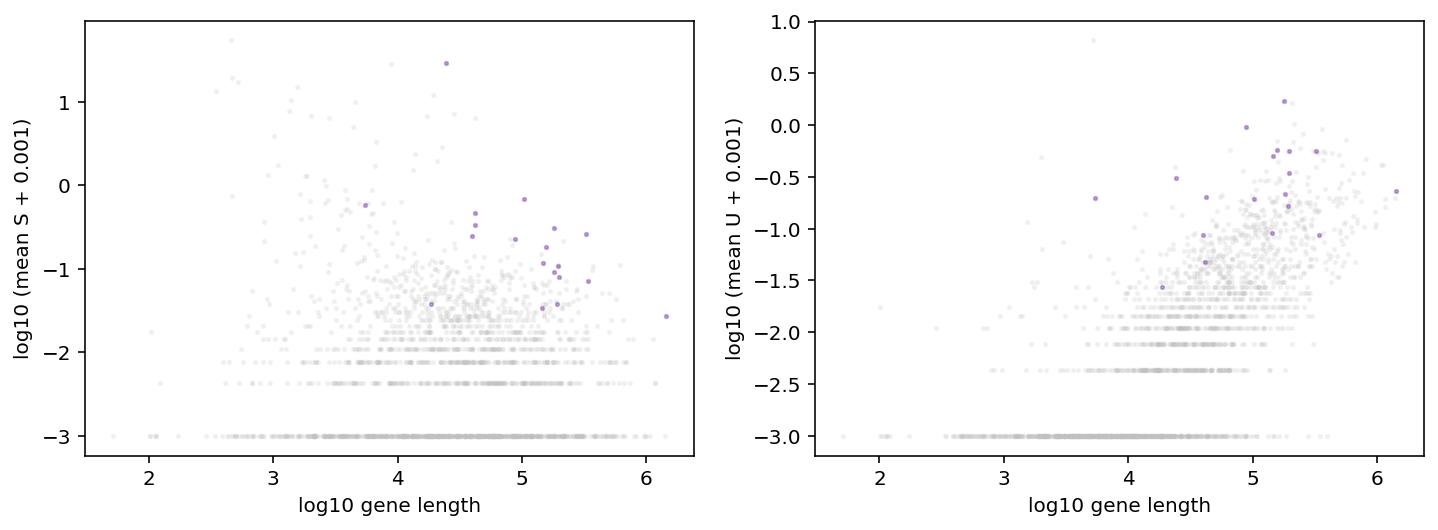

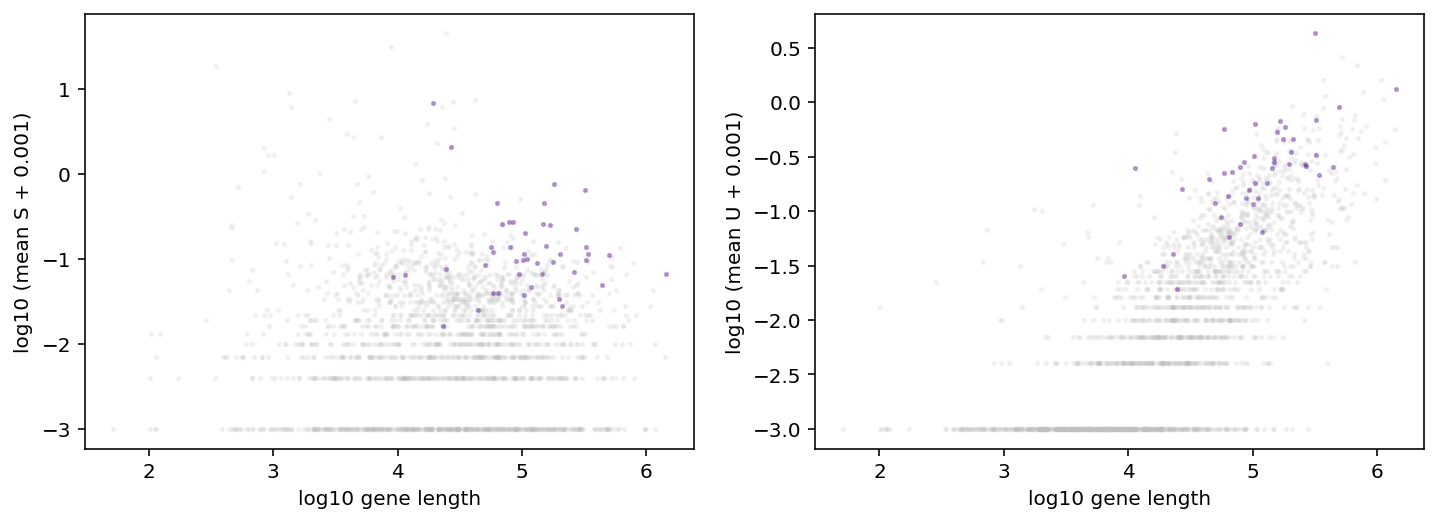

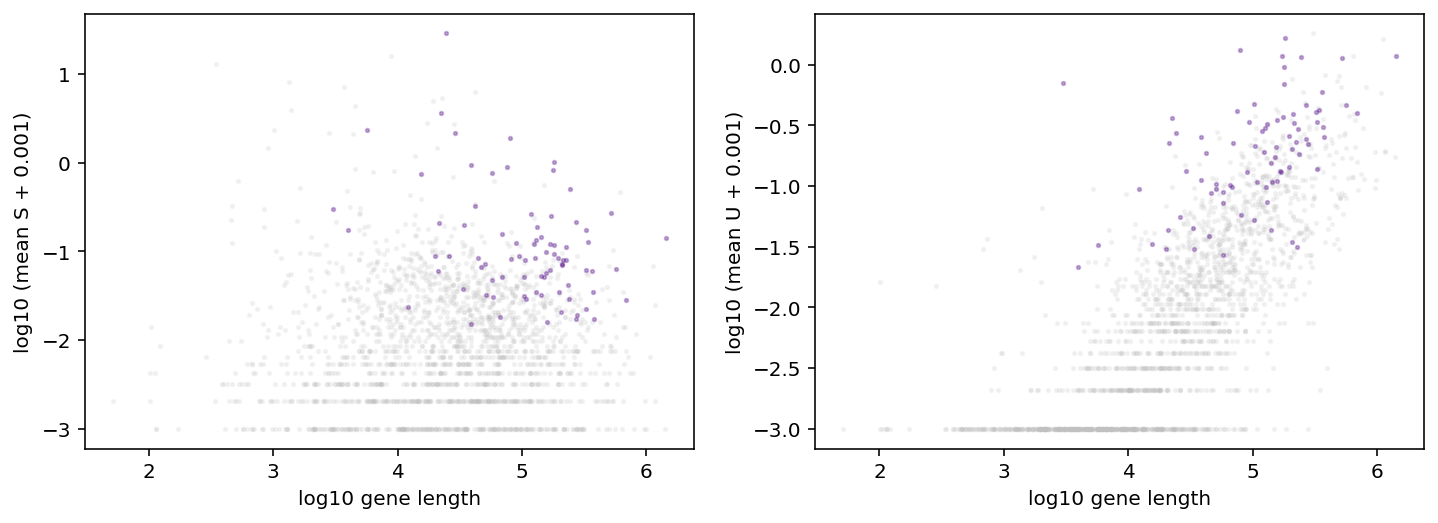

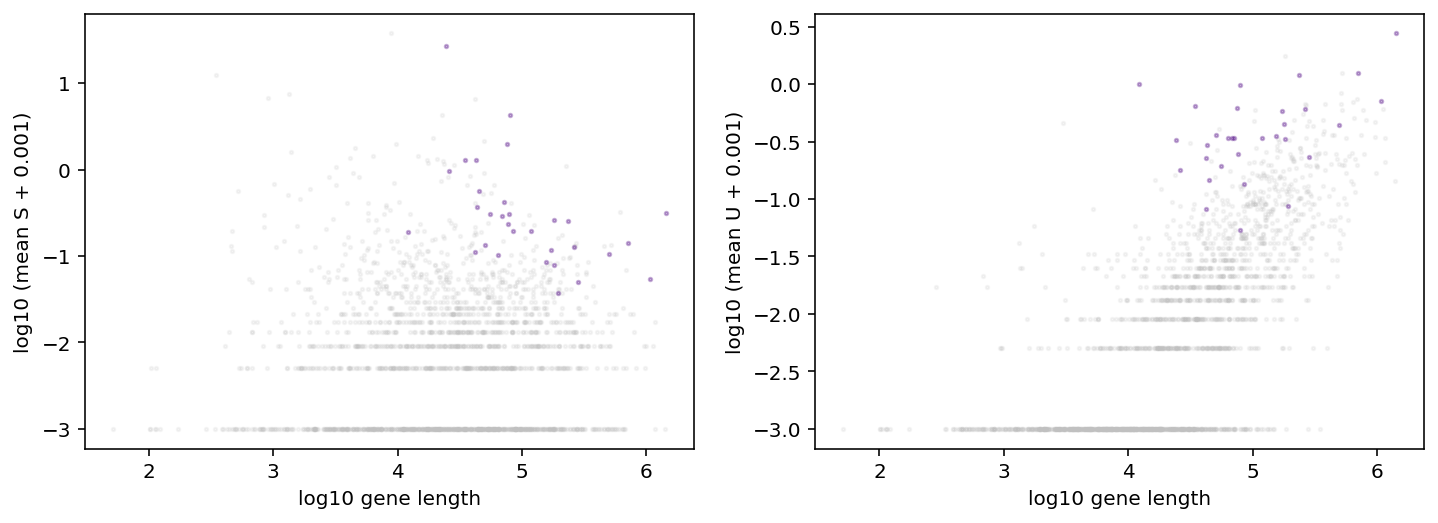

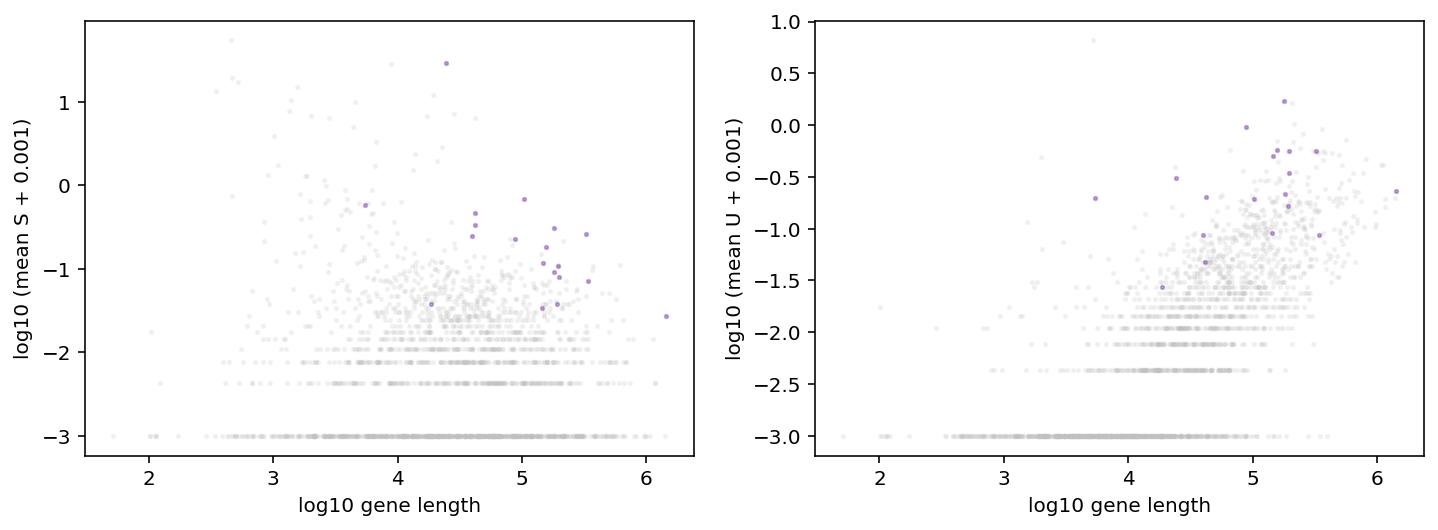

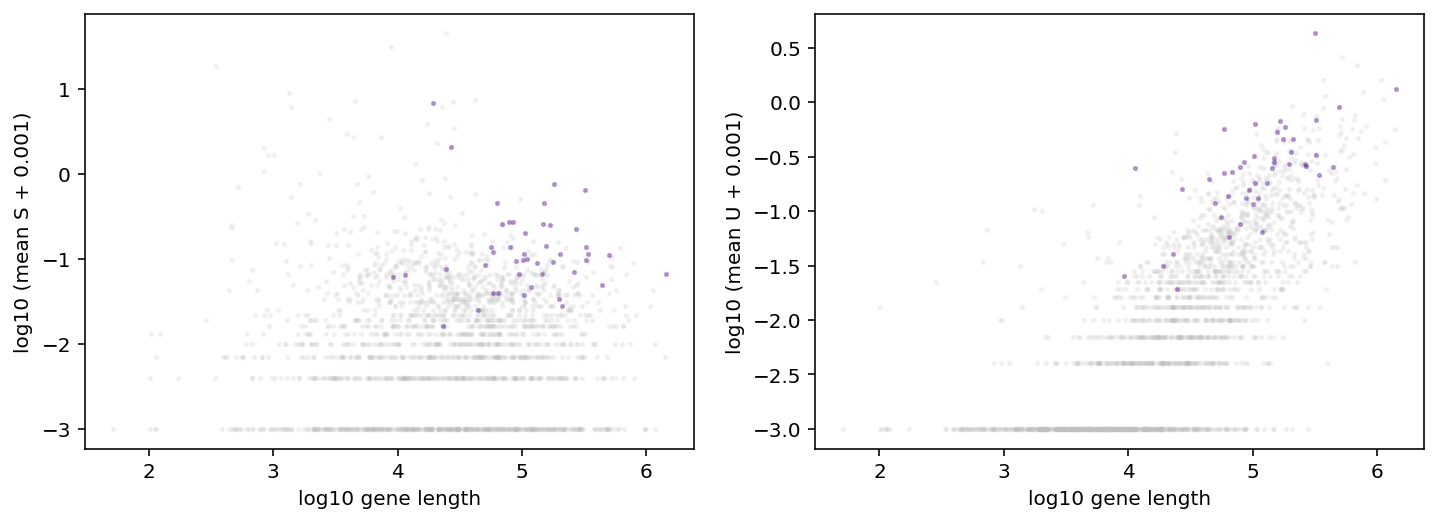

In [43]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='liver_MM',batch_id=1,\
                                             datestring='230420', n_genes=1900,\
                                             exp_filter_threshold=None,cf=cf)  #1900

Check k-means inits

INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k1
INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k1/raw.sd.
(1802, 1900)
(1802, 1900)
(1802, 1900)


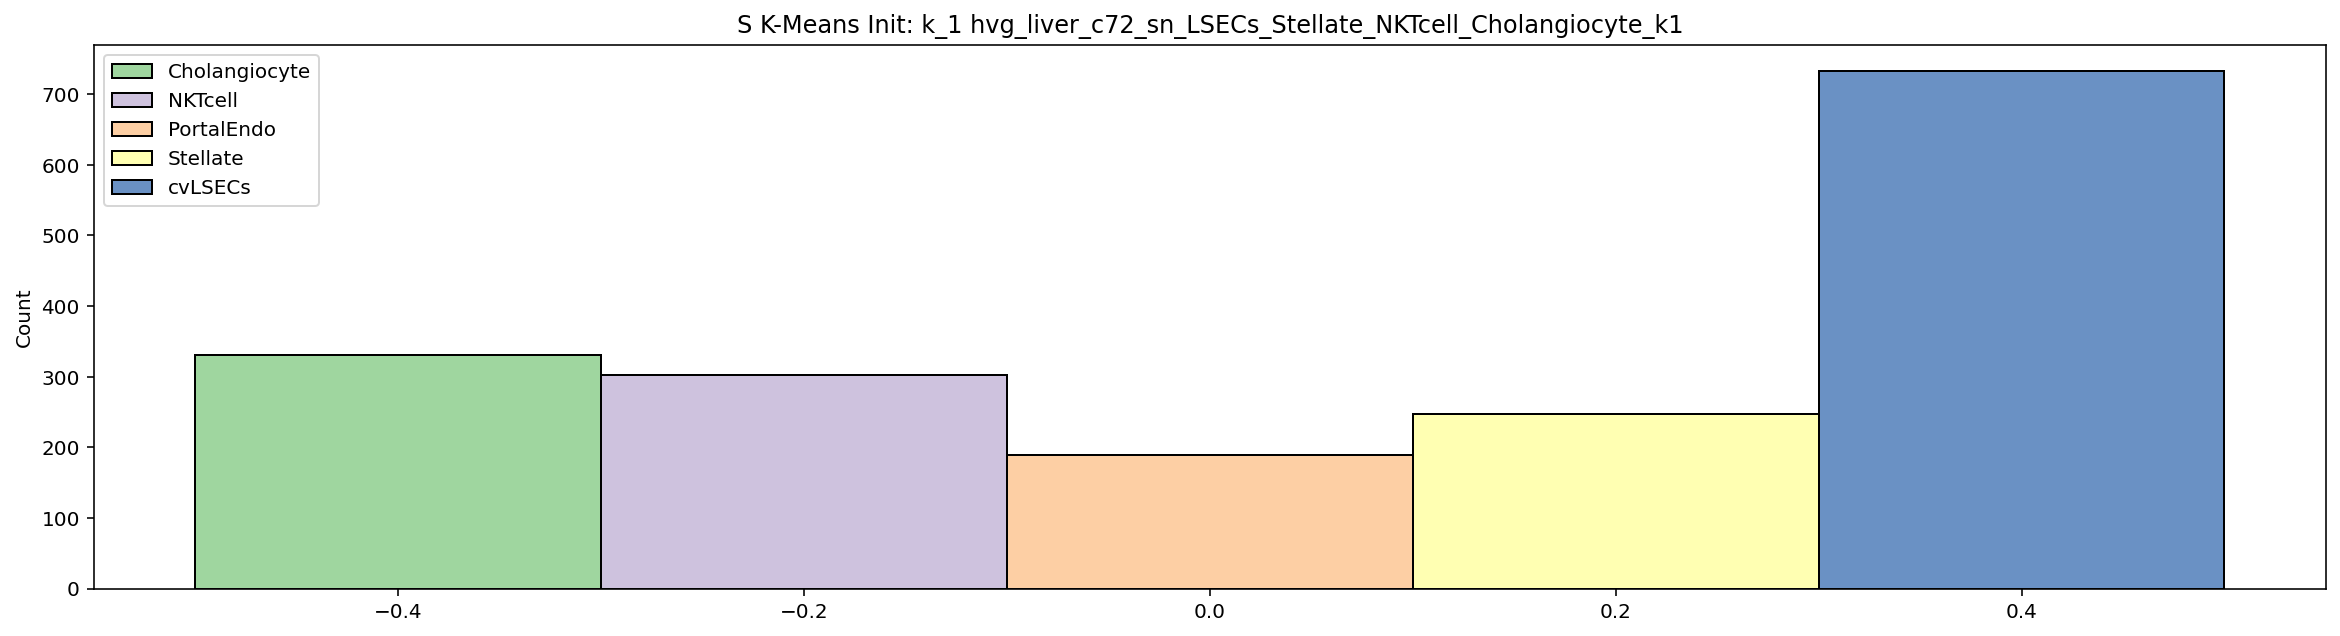

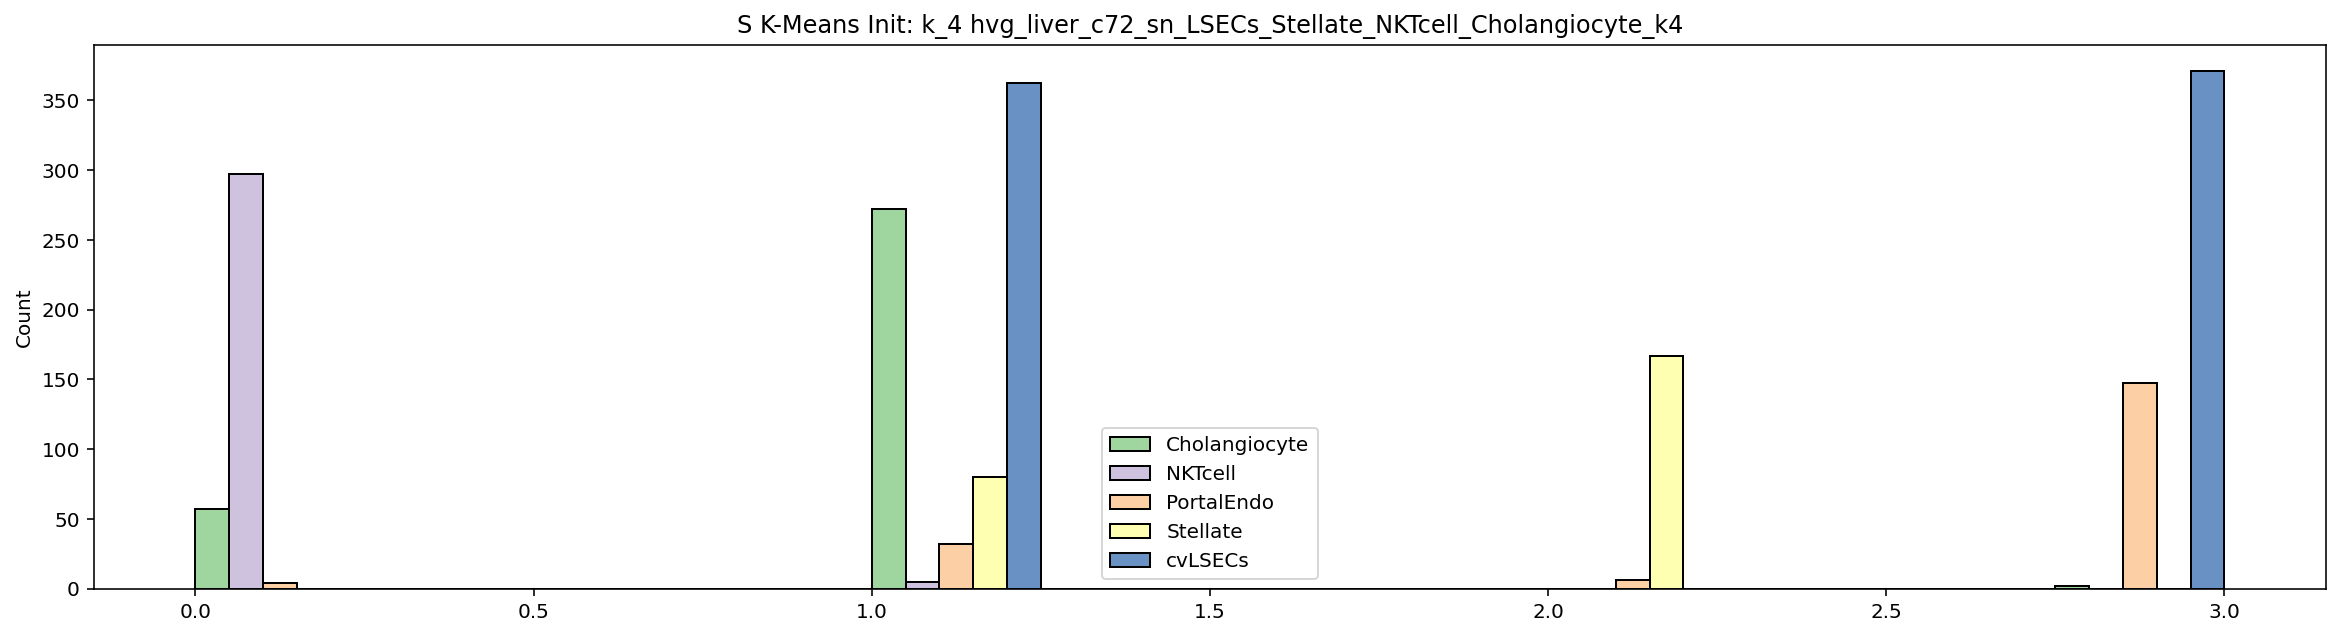

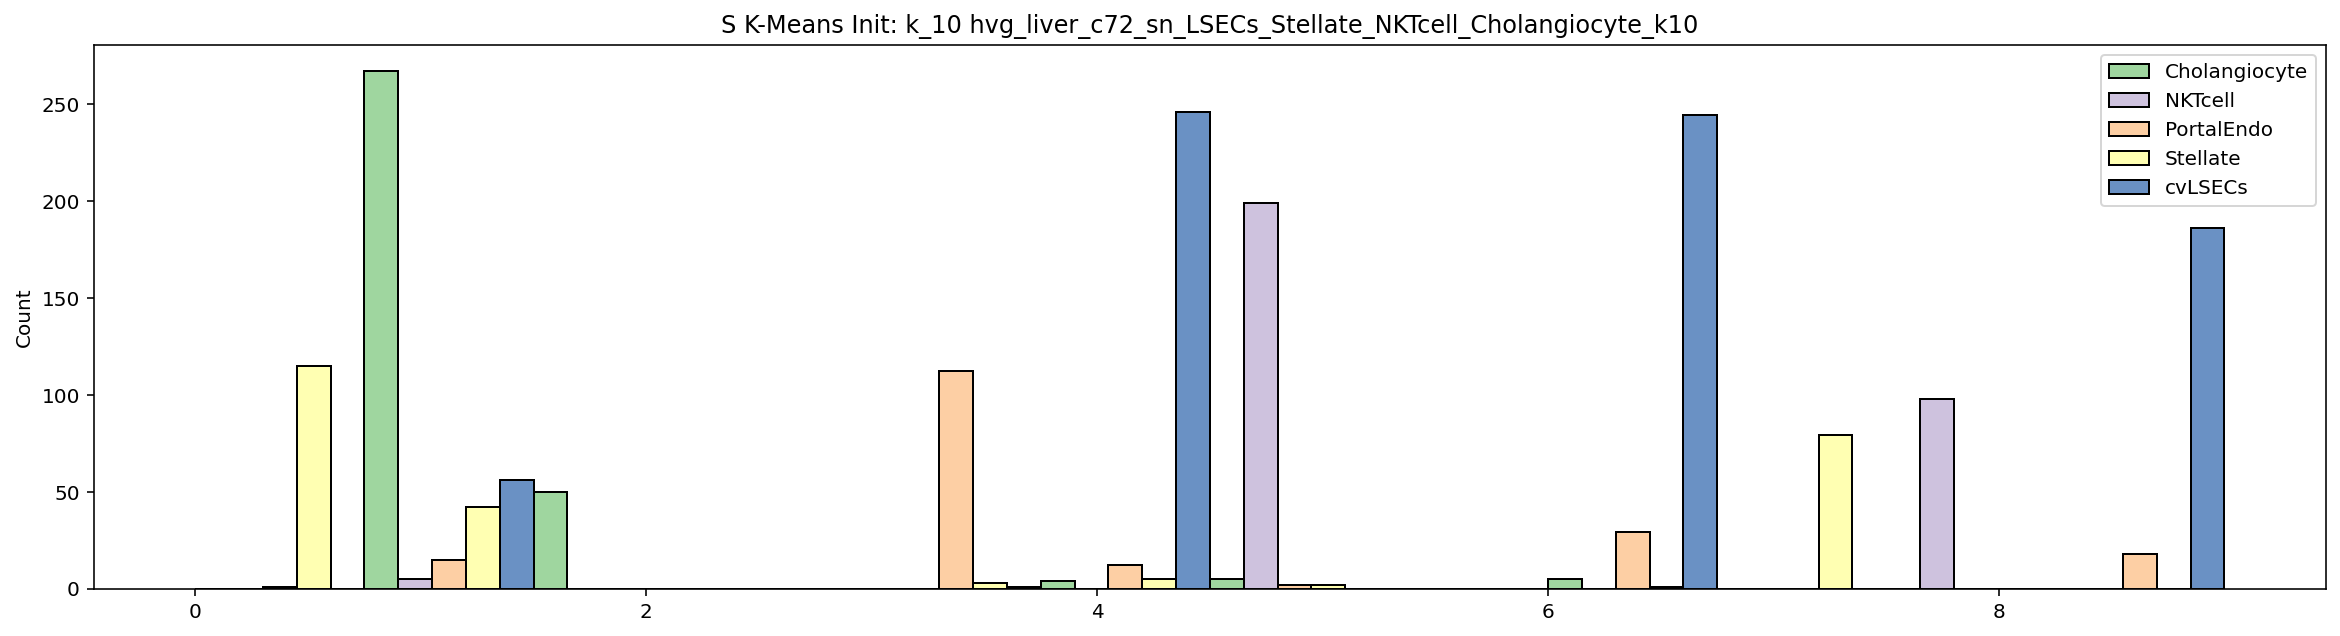

In [51]:
#For easier demonstration
#Check initializations of clusters
which = 0
search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

for i in range(3):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Accent',multiple="dodge")
    plt.title('S K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[which])




(1802, 1900)
(1802, 1900)
(1802, 1900)


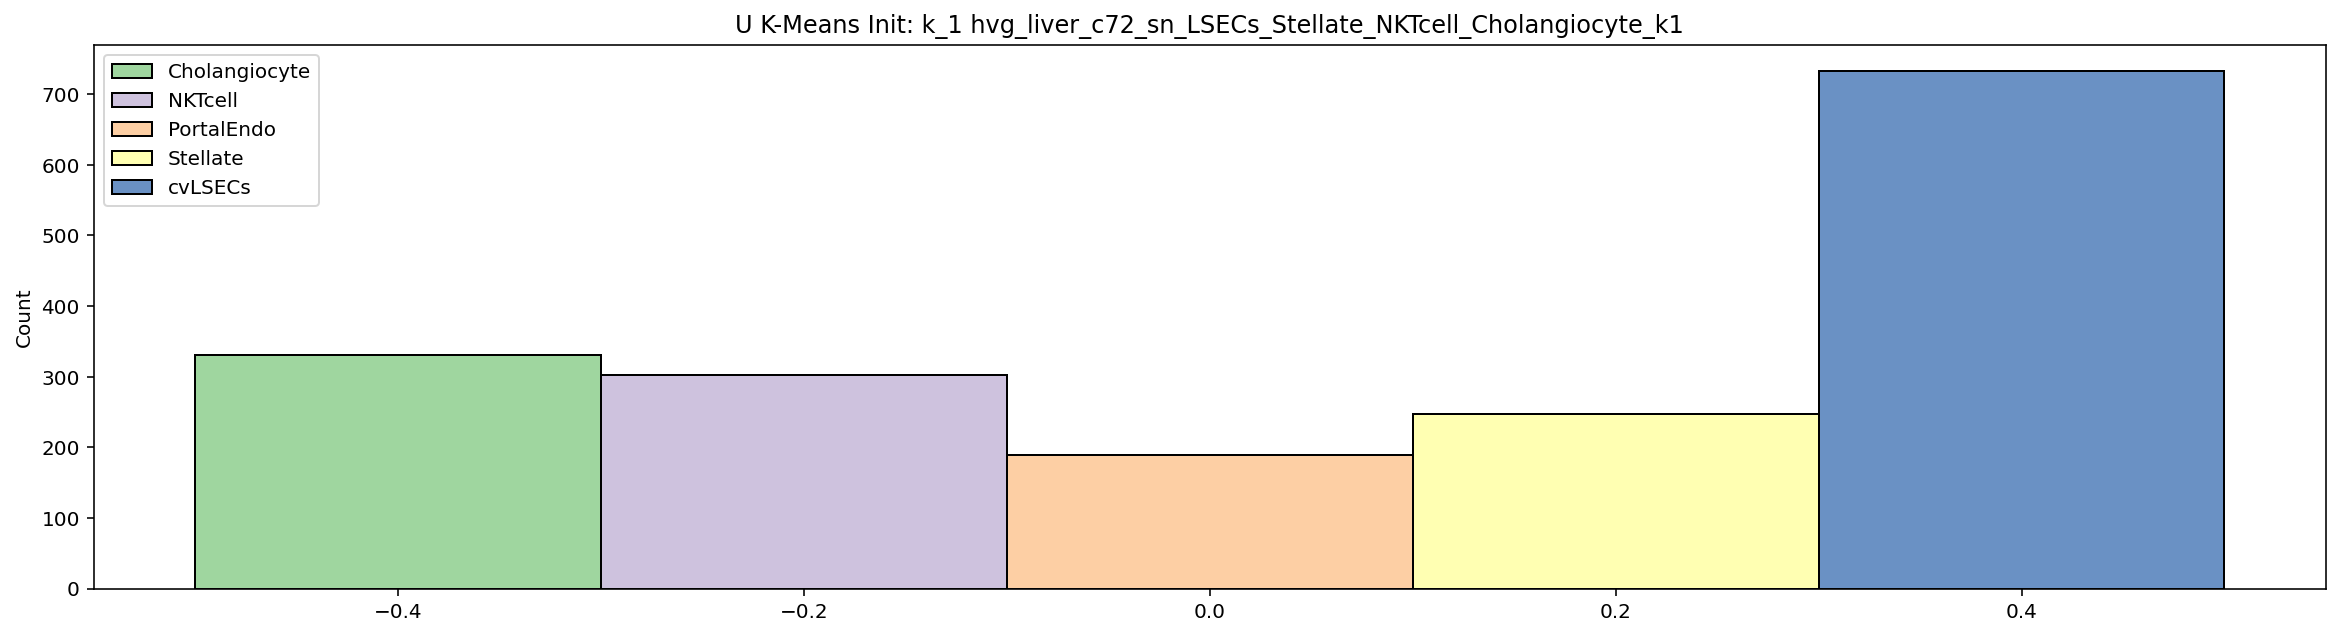

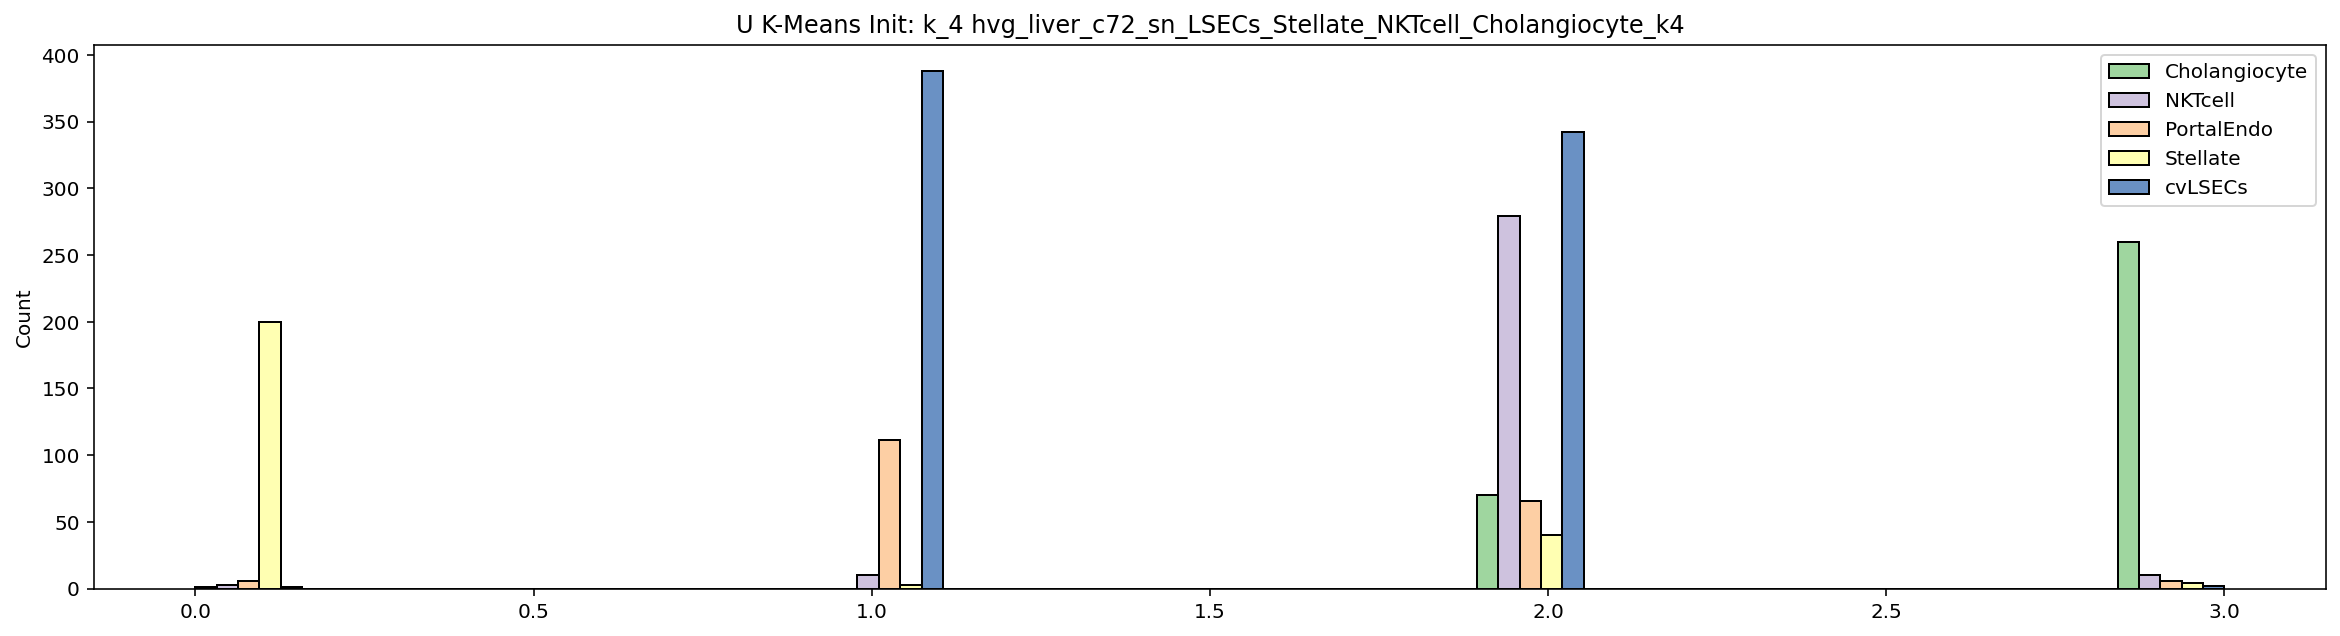

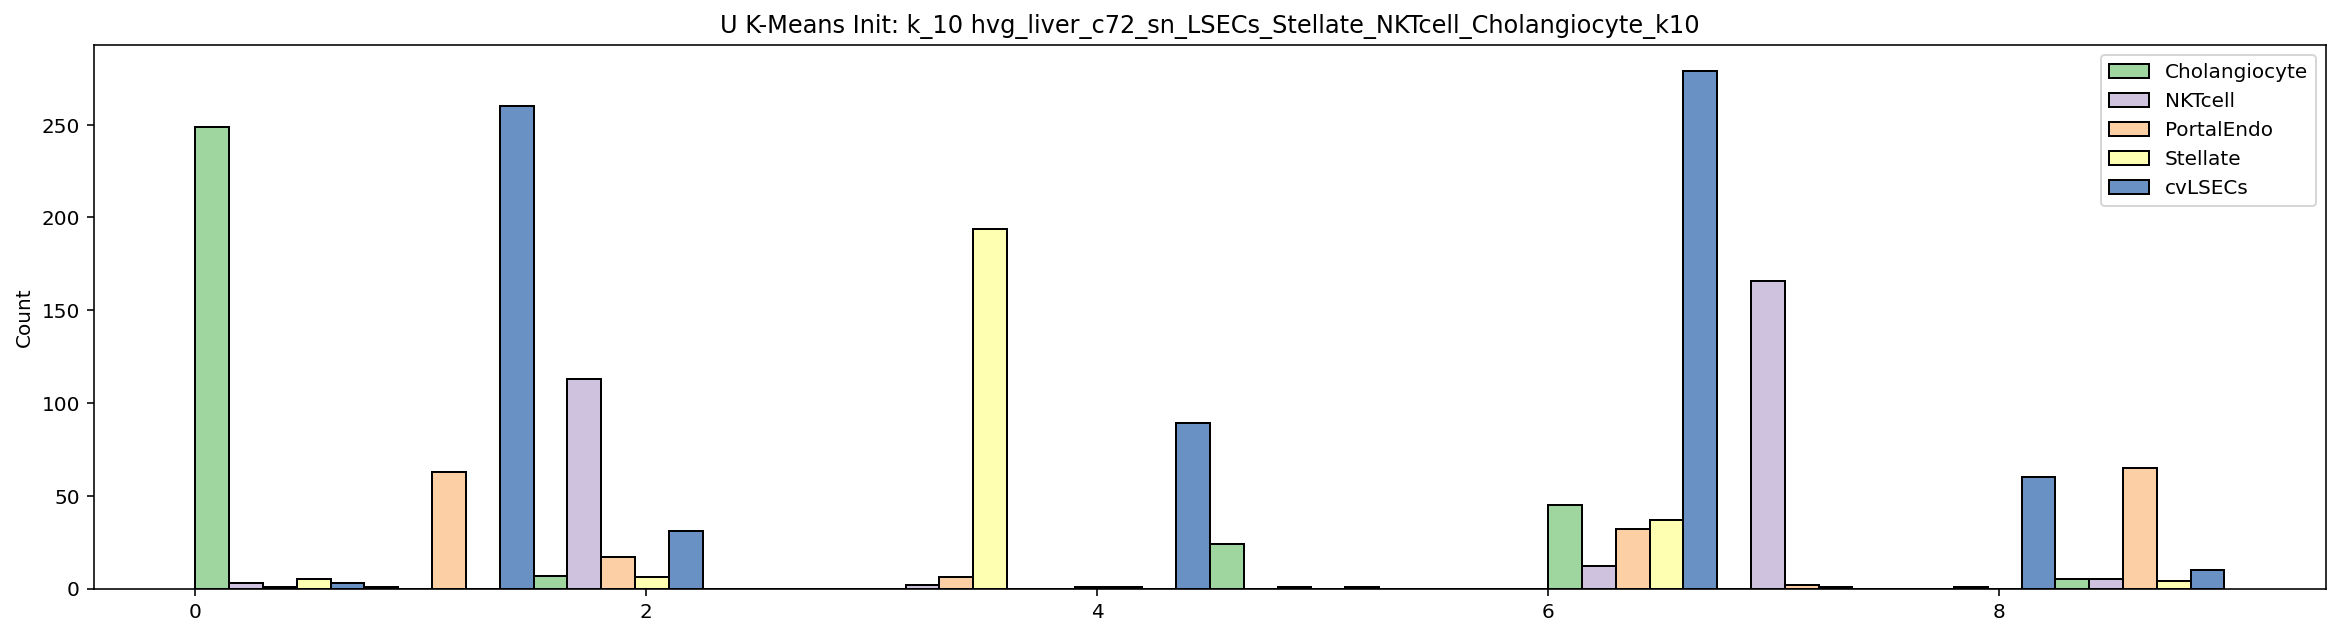

In [53]:
for i in range(3):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)+1
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Accent',multiple="dodge")
    plt.title('U K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[which])


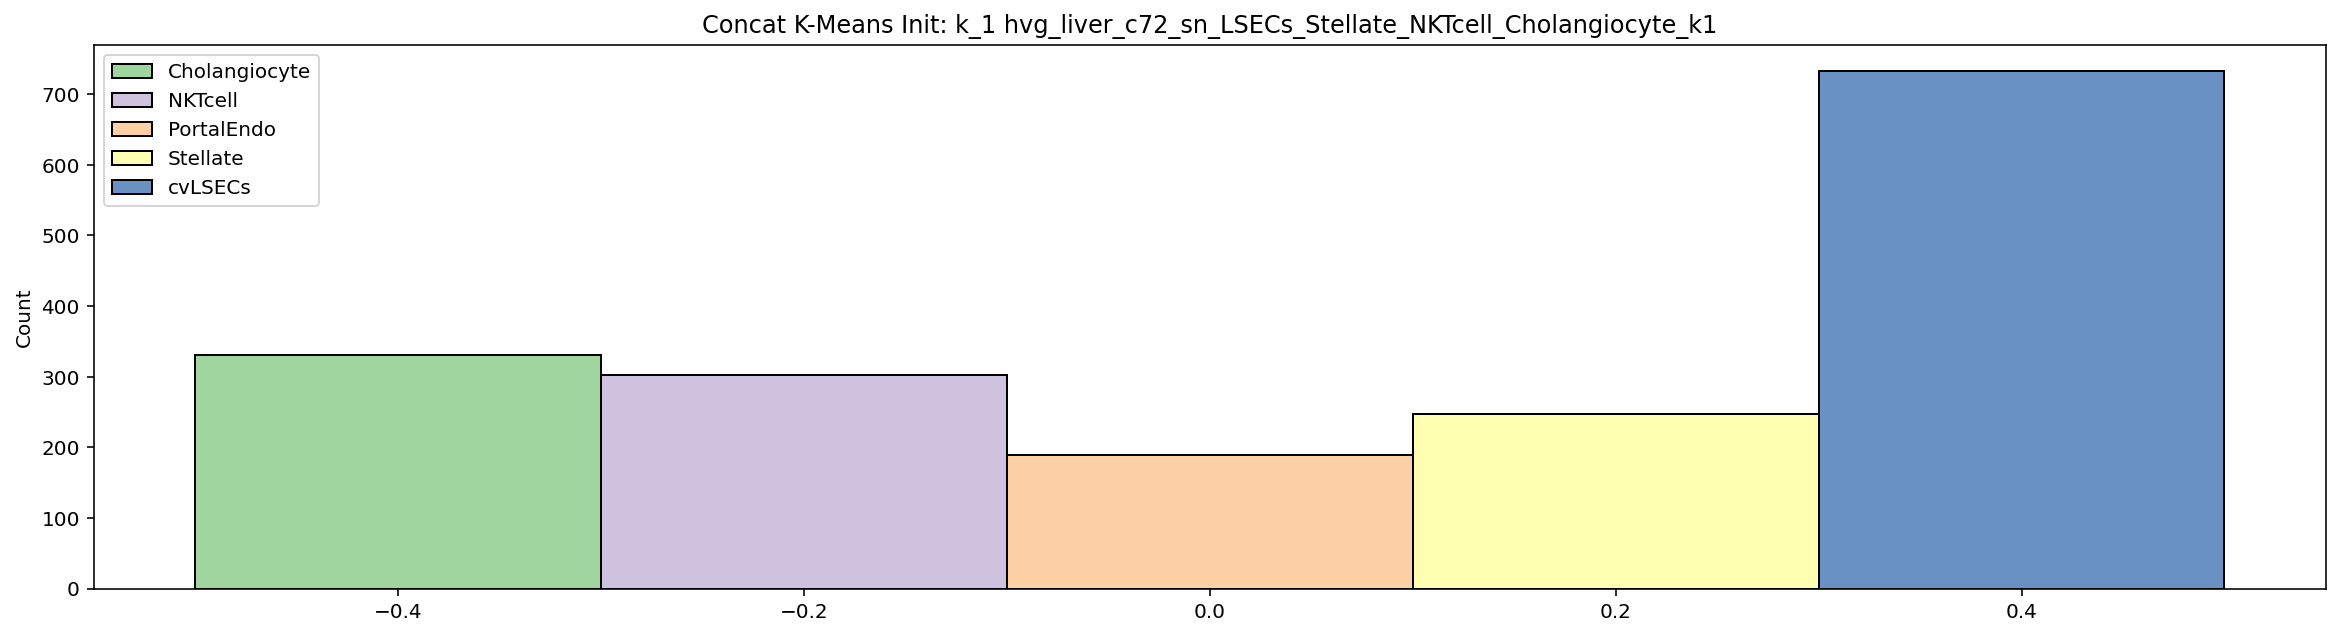

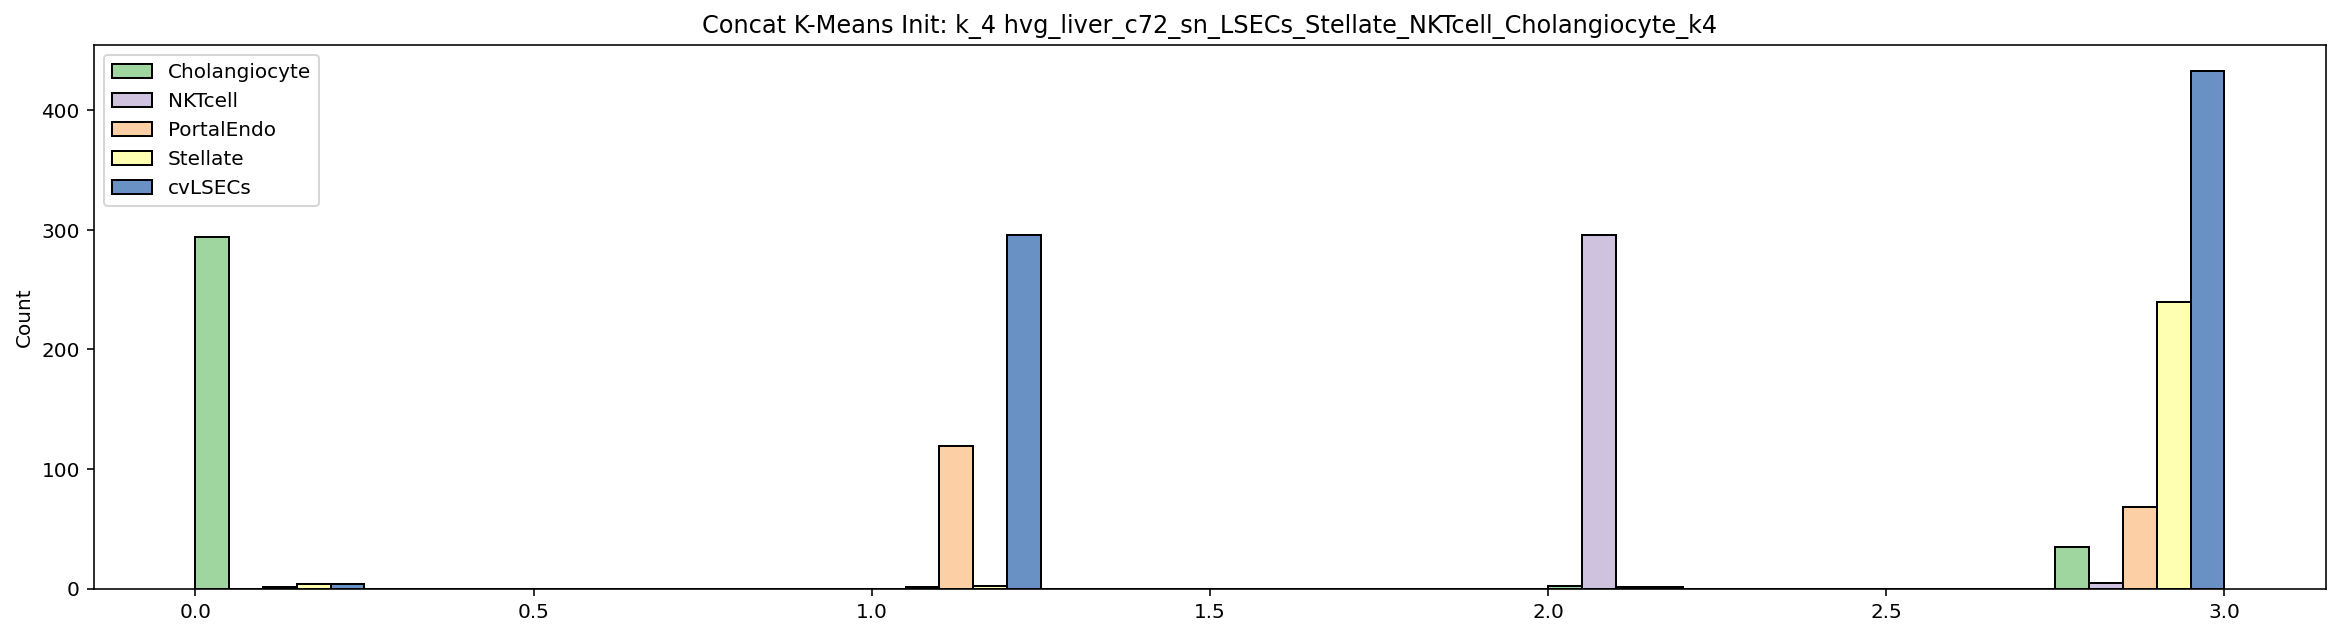

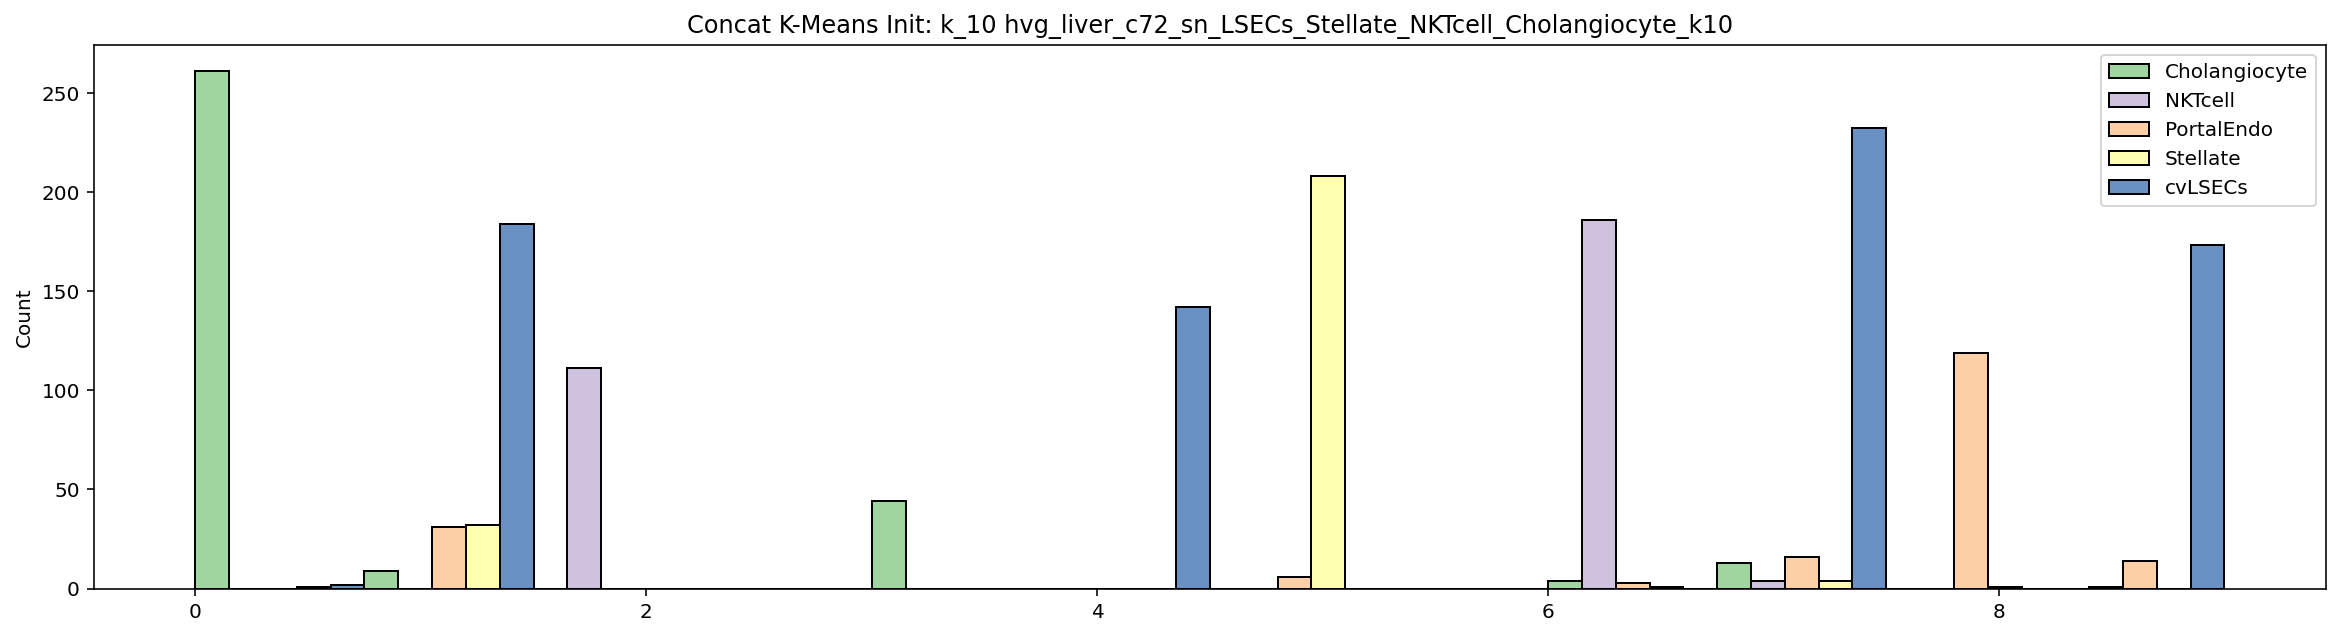

In [55]:
for i in range(3):
    which = i
#     search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
#                 dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    plt.figure(figsize=(20,5))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Accent',multiple="dodge")
    plt.title('Concat K-Means Init: '+'k_'+str(ks[which])+' '+dataset_names[i])

    
    

## **Run MM/Monod Inference**

v----------- Only Run Once -----------v

In [56]:
#Define bounds, 
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-9, -4] #-7.5, -2
samp_ub = [-4, 1.5] #-5.5, 0
# gridsize = [5,6]
gridsize = [10,11]


In [57]:
len(dataset_names)

14

In [58]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(dataset_names)-4,len(dataset_names)): 

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string,viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs
INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [05:50<00:00,  3.19s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs/Bursty_Poisson_10x11/analysis_figures already exists.
INFO:root:Runtime: 351.6 seconds.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Stellate/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Stellate/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_Stellate
INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Stellate/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [05:15<00:00,  2.87s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Stellate/Bursty_Poisson_10x11/analysis_figures already exists.


INFO:root:Runtime: 316.6 seconds.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_NKTcell/Bursty_Poisson_10x11 created.
INFO:root:Global inference parameters stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_NKTcell/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_NKTcell
INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_NKTcell/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [09:45<00:00,  5.32s/it]

INFO:root:Parallelized grid scan complete.


INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_NKTcell/Bursty_Poisson_10x11/analysis_figures created.
INFO:root:Runtime: 585.8 seconds.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Cholangiocyte/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Cholangiocyte/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_Cholangiocyte
INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Cholangiocyte/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [05:56<00:00,  3.24s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Cholangiocyte/Bursty_Poisson_10x11/analysis_figures already exists.


INFO:root:Runtime: 357.1 seconds.


In [61]:
result_strings = [i+'/Bursty_Poisson_10x11/grid_scan_results.res' for i in dataset_strings[(len(dataset_names)-4):]]


INFO:root:Grid scan results loaded from ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Stellate/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_NKTcell/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Cholangiocyte/Bursty_Poisson_10x11/grid_scan_results.res.


Text(0, 0.5, '$\\log_{10} \\lambda_M$')

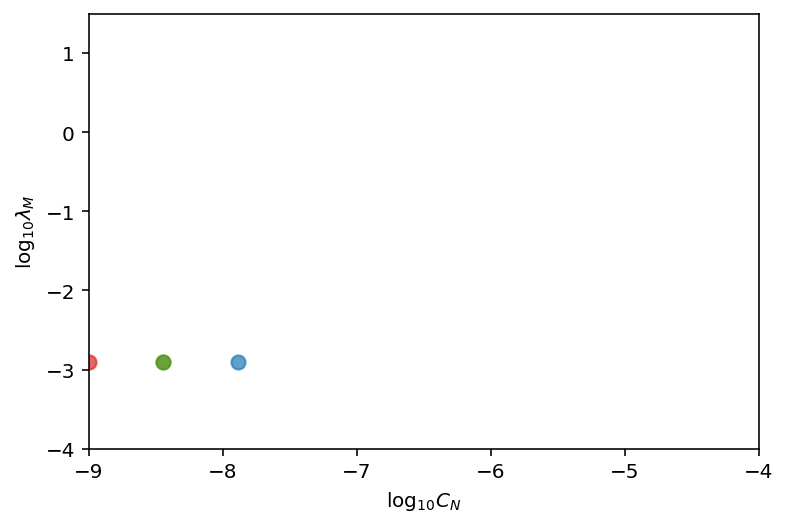

In [64]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
plt.figure()
for r in sr:
    r.find_sampling_optimum()
    plt.scatter(r.samp_optimum[0],r.samp_optimum[1],alpha=0.7,s=50)
    
plt.xlim([-9,-4])
plt.ylim([-4,1.5])

plt.xlabel(r'$\log_{10} C_N$')
plt.ylabel(r'$\log_{10} \lambda_M$')

In [66]:
#Find closest technical param in grid, to centroid of technical params on plot
arbitrary_params = np.asarray([-8.5,-3]) #-8,-2.5
arbitrary_ind = np.argmin(((sr[0].sp.sampl_vals-arbitrary_params)**2).sum(1))
arbitrary_pars = sr[0].sp.sampl_vals[arbitrary_ind]
print(arbitrary_pars)

(-8.444444444444445, -2.9)


^----------- Only Run Once -----------^

In [67]:
#Define bounds, choose 'centroid'
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [arbitrary_pars[0], arbitrary_pars[1]] 
samp_ub = [arbitrary_pars[0], arbitrary_pars[1]] 
# gridsize = [5,6]
gridsize = [1,1]

In [68]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(dataset_names)-4,len(dataset_names)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)
    

INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs
INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:52<00:00, 52.42s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 53.2 seconds.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Stellate/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Stellate/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_Stellate


INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Stellate/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:48<00:00, 48.72s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Stellate/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 49.4 seconds.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_NKTcell/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_NKTcell/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_NKTcell


INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_NKTcell/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:23<00:00, 143.61s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_NKTcell/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 144.5 seconds.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Cholangiocyte/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Cholangiocyte/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_Cholangiocyte


INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Cholangiocyte/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:53<00:00, 53.03s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Cholangiocyte/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 53.8 seconds.


In [69]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings[len(dataset_names)-4:]]

In [70]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Stellate/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_NKTcell/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Cholangiocyte/Bursty_Poisson_1x1/grid_scan_results.res.


**Run Mixture Model**

In [71]:
epochs = 20

In [ ]:
result_strings = []
for i in range(num_ks): #rlen(chosen)*num_ks
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k1/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k1
INFO:root:1999 features observed, 1976 match genome annotations. 1953 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_LSECs_Stellate_NKTcell_Cholangiocyte_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:49<00:00, 349.95s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:49<00:00, 349.30s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1277037.5816466631

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:47<00:00, 347.93s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1277037.5816466631

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:50<00:00, 350.88s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1277037.5816466631

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:51<00:00, 351.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1277037.5816466631

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:49<00:00, 349.93s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1277037.5816466631

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:50<00:00, 350.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1277037.5816466631

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:49<00:00, 349.86s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1277037.5816466631

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:52<00:00, 352.99s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -1277037.5816466631

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


  0%|                                                                                                           | 0/1 [00:00<?, ?it/s]

## **Analysis of Results**

In [ ]:
#Plot cluster concordance with true labels and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_dict = dict(zip(np.unique(list(true)),range(len(np.unique(list(true))))))
    true = [true_dict[x] for x in true]                
    
    true_copy = list(true)

    
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Pastel1',multiple="dodge")
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [ ]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,ks,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [ks[i]]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.mean(np.sum(np.array(results[i].all_klds)[:,:,list(np.unique(results[i].assigns))],axis=2),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


In [280]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[0:num_ks]] #0:len(chosen)*num_ks
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

In [281]:
assign_dict = dict(zip(np.unique(list(all_assigns)),range(len(np.unique(list(all_assigns))))))
new_assigns = [assign_dict[x] for x in all_assigns]
print(assign_dict)

{'CentralHep': 0, 'Cholangiocyte': 1, 'InterHep': 2, 'PortalEndo': 3, 'PortalHep': 4, 'Stellate': 5, 'cvLSECs': 6}


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


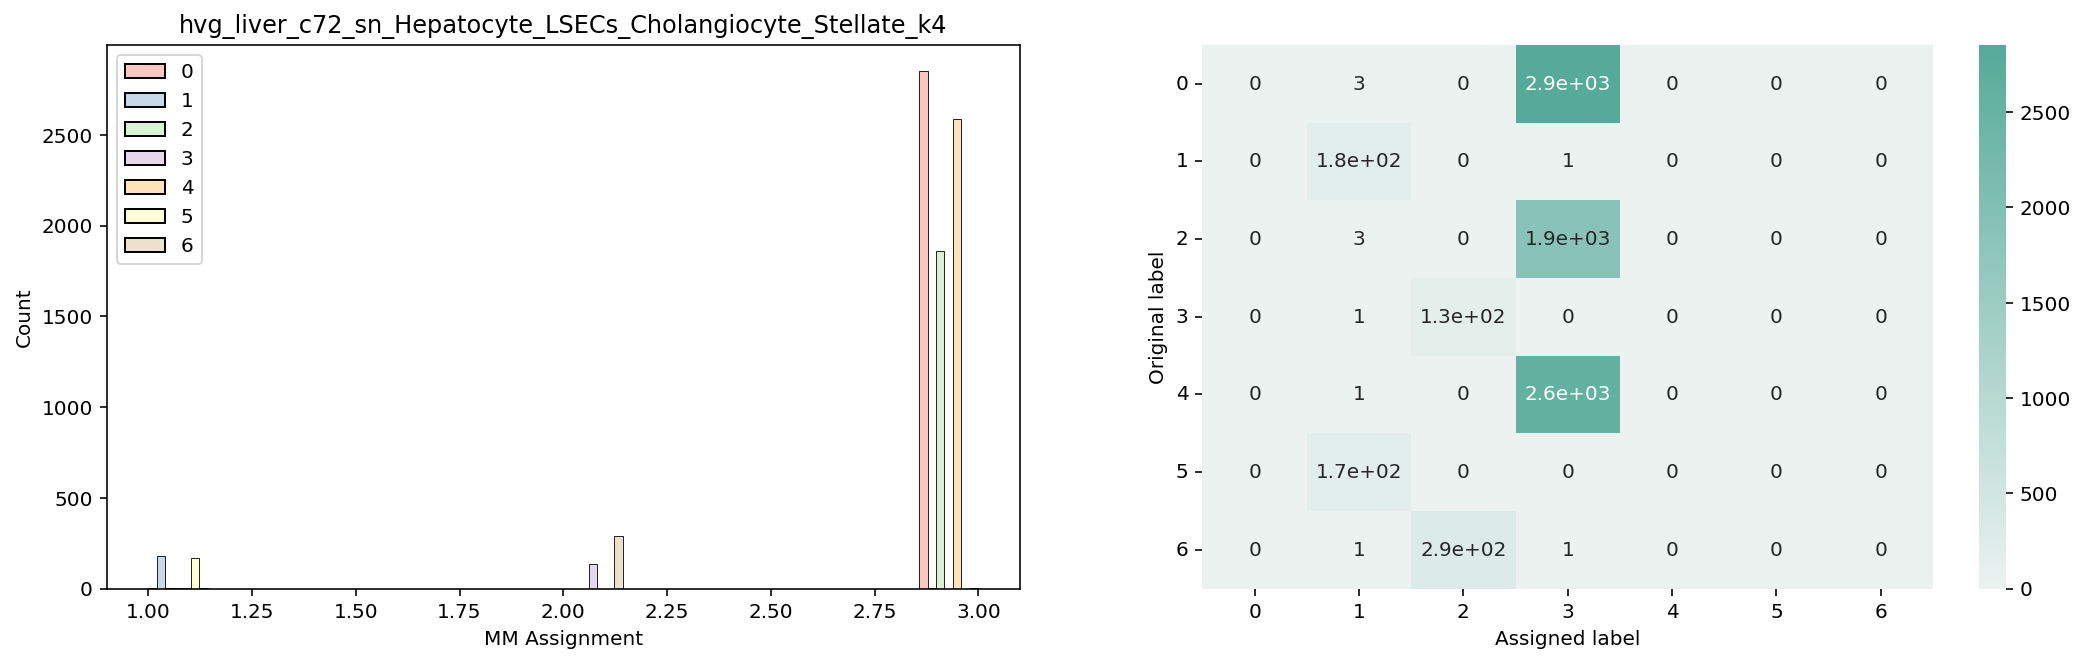

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


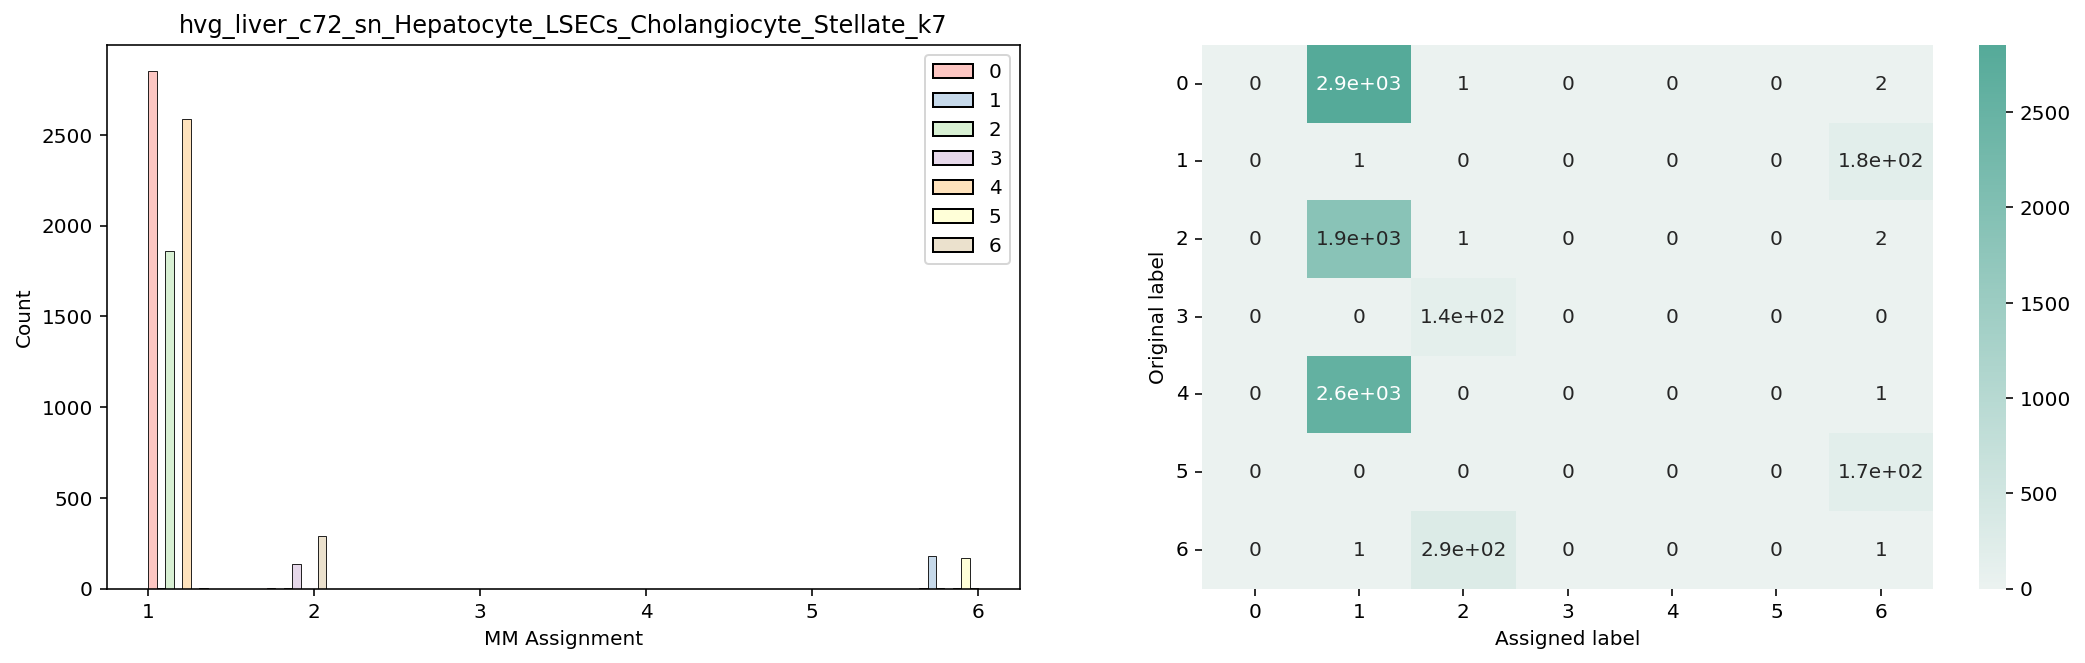

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(8, 8)


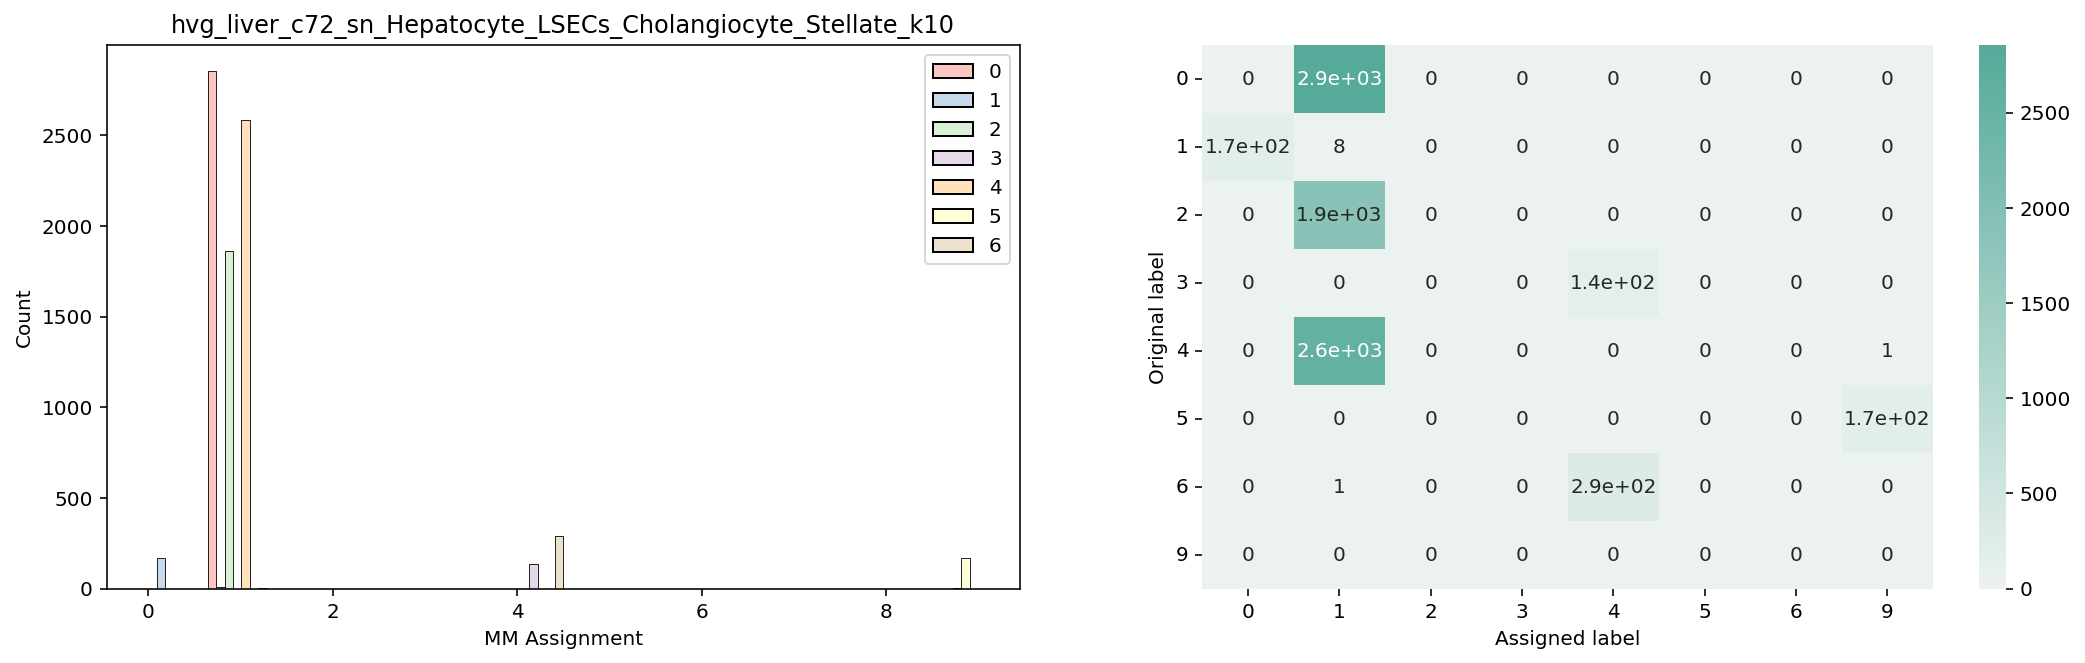

In [282]:
for i in range(len(grid_point_results)):
    r = grid_point_results[i]
    title = r.inference_string.replace('./fits/gg_230420_025_liver_MM_1/','')
    title = title.replace('/Bursty_Poisson_1x1','')
    vis_assign(np.array(new_assigns),r.assigns,title,figsize=(25, 5))


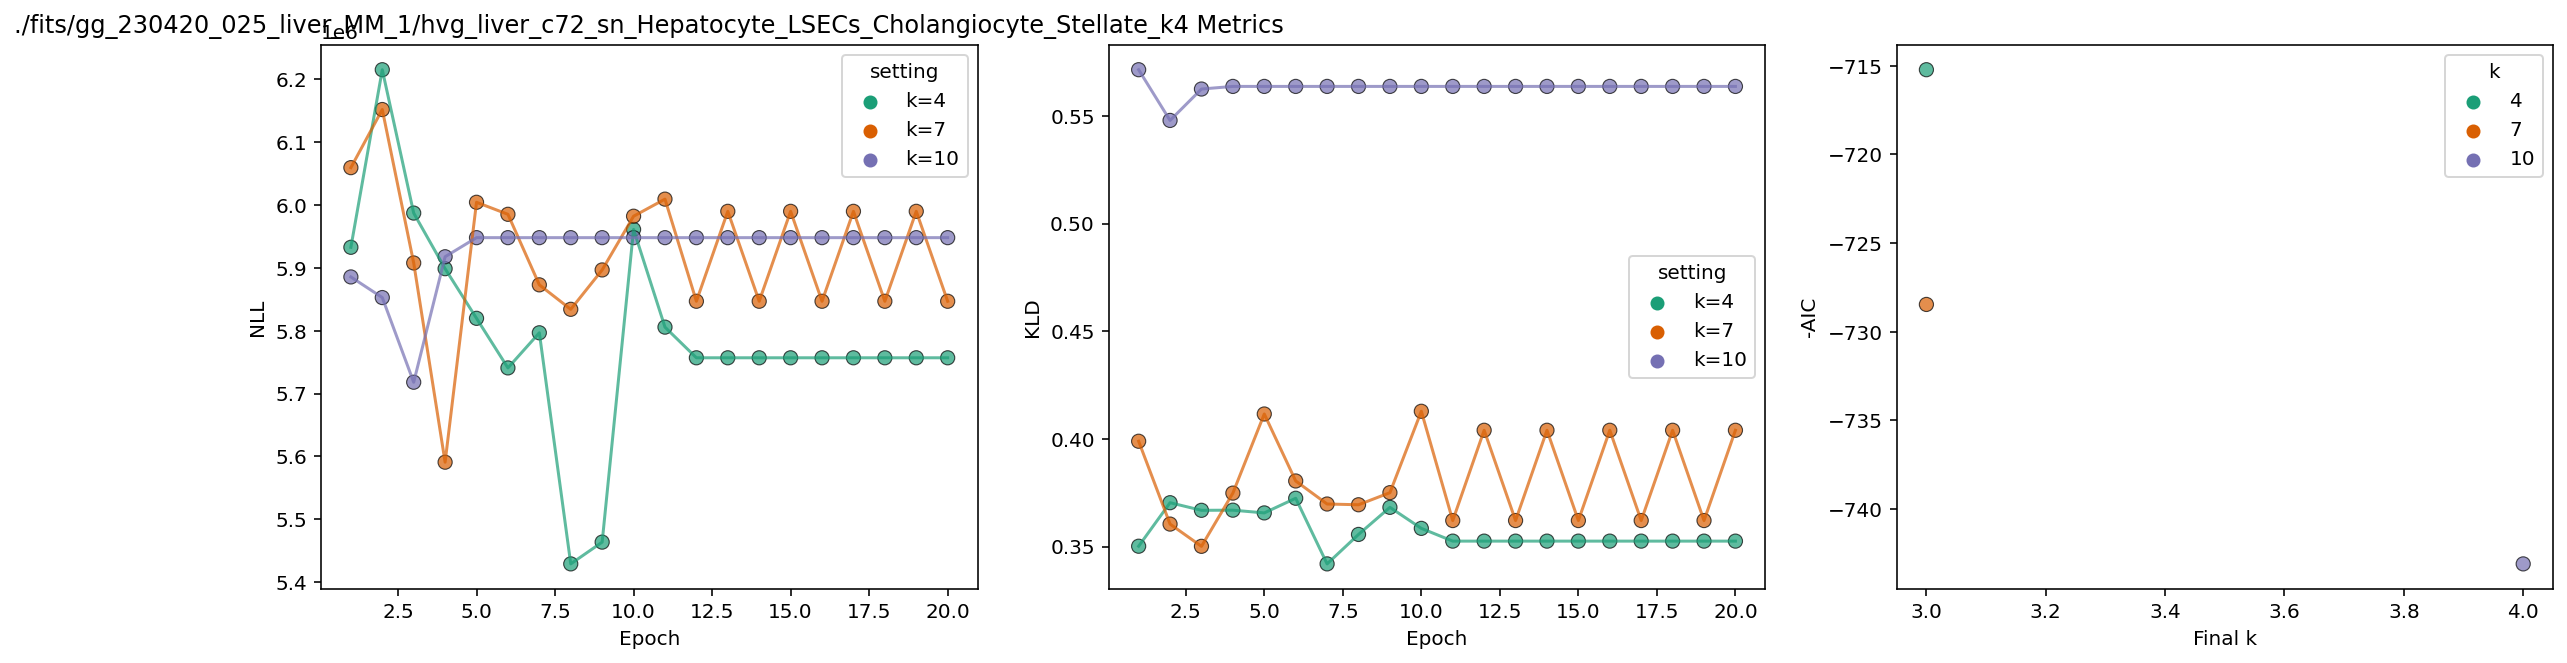

In [285]:
for i in range(0, len(grid_point_results), num_ks):
    r = grid_point_results[i:i+num_ks]
    title = dataset_strings[i]+' Metrics'
    vis_metrics(r,title,ks[0:num_ks],figsize=(20,5))

In [286]:
glob_samp = np.asarray([arbitrary_pars[0], arbitrary_pars[1]])

In [287]:
class BurstModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p

        
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]
        elif self.seq_model == "Poisson":
            g = np.exp((np.power(10, samp))[:, None, None] * g) - 1

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        
        
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        
        
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        
        Pss = Pss.squeeze()
        return Pss

In [288]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

In [289]:
#Check results for burst size > 1
def get_logL(ps,counts,search_data):
    bs = ps[:,0]
    betas = ps[:,1]
    gammas = ps[:,2]
    
    EPS=1e-15
    
    logL = 0
    
    for g in range(search_data.n_genes):
        

        x = counts[:,g,:].T
        x = x.astype(int)
        
        b = 10**bs[g]
        beta = 10**betas[g]
        gamma = 10**gammas[g]
        
        
        
        g_len = search_data.gene_log_lengths[g] #lens_sub[g]

        lam_n = 10**((glob_samp[0]) + g_len)
        lam_m = 10**(glob_samp[1])

        p = np.log10(np.asarray([b,beta,gamma])) #[b,beta,gamma]
        burst_model = BurstModel('Poisson')


        proposal = burst_model.get_Pss(p,search_data.M[:, g],np.log10([lam_n,lam_m]))

        proposal[proposal < EPS] = EPS

        proposal = proposal[tuple(x)]
        logL += np.sum(np.log(proposal))
        
    return logL

INFO:root:Beginning data extraction.
INFO:root:Dataset: hvg_liver_c72_sn_Hepatocyte_LSECs_Cholangiocyte_Stellate_k4
INFO:root:1999 features observed, 1985 match genome annotations. 1971 were unique.
INFO:root:Gene list extracted from ./fits/gg_230420_025_liver_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Hepatocyte_LSECs_Cholangiocyte_Stellate_k4/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230420_025_liver_MM_1/hvg_liver_c72_sn_Hepatocyte_LSECs_Cholangiocyte_Stellate_k4/raw.sd.


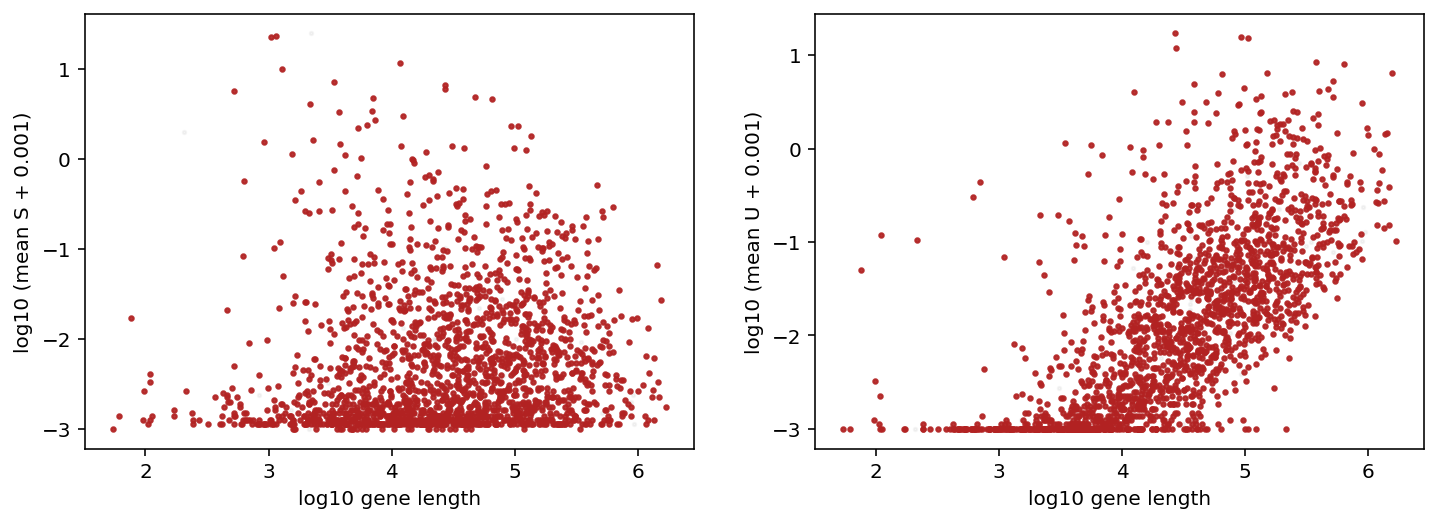

In [290]:
#0,1,7 lowest_b_sim_k3
which = 0
search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, dataset_attr_names=attribute_names,cf=cf[which])


In [291]:
dataset_names

['hvg_liver_c72_sn_Hepatocyte_LSECs_Cholangiocyte_Stellate_k4',
 'hvg_liver_c72_sn_Hepatocyte_LSECs_Cholangiocyte_Stellate_k7',
 'hvg_liver_c72_sn_Hepatocyte_LSECs_Cholangiocyte_Stellate_k10',
 'hvg_liver_c72_sn_Hepatocyte_LSECs_Cholangiocyte_Stellate_k4',
 'hvg_liver_c72_sn_Hepatocyte_LSECs_Cholangiocyte_Stellate_k7',
 'hvg_liver_c72_sn_Hepatocyte_LSECs_Cholangiocyte_Stellate_k10',
 'hvg_liver_c72_sn_Hepatocyte',
 'hvg_liver_c72_sn_LSECs',
 'hvg_liver_c72_sn_Cholangiocyte',
 'hvg_liver_c72_sn_Stellate',
 'hvg_liver_c72_sn_Hepatocyte',
 'hvg_liver_c72_sn_LSECs',
 'hvg_liver_c72_sn_Cholangiocyte',
 'hvg_liver_c72_sn_Stellate']

(1000, 3, 2)

In [300]:
#Get logl for counts in each cluster, for each cluster params
logLs_k4 = []

r = grid_point_results[0]
print(r.param_estimates.shape)

ps = r.param_estimates[:,:,1]
counts = search_data.layers[:,:,r.assigns == 1].T
logLs_k4 += [get_logL(ps,counts,search_data)]

ps = r.param_estimates[:,:,2]
counts = search_data.layers[:,:,r.assigns == 2].T
logLs_k4 += [get_logL(ps,counts,search_data)]

ps = r.param_estimates[:,:,3]
counts = search_data.layers[:,:,r.assigns == 3].T
logLs_k4 += [get_logL(ps,counts,search_data)]

print(np.sum(logLs_k4+np.log(np.array([r.weights[1],r.weights[2],r.weights[3]]))))

(1900, 3, 4)
-5753805.589204778


In [299]:
#Get logl for counts in each cluster, for each cluster params
logLs_k7 = []

r = grid_point_results[1]
print(r.param_estimates.shape)

ps = r.param_estimates[:,:,1]
counts = search_data.layers[:,:,r.assigns == 1].T
logLs_k7 += [get_logL(ps,counts,search_data)]

ps = r.param_estimates[:,:,2]
counts = search_data.layers[:,:,r.assigns == 2].T
logLs_k7 += [get_logL(ps,counts,search_data)]

ps = r.param_estimates[:,:,6]
counts = search_data.layers[:,:,r.assigns == 6].T
logLs_k7 += [get_logL(ps,counts,search_data)]

print(np.sum(logLs_k7+np.log(np.array([r.weights[1],r.weights[2],r.weights[6]]))))

(1900, 3, 7)
-5986737.168843176


In [298]:
#Get logl for counts in each cluster, for each cluster params
logLs_k10 = []

r = grid_point_results[2]
print(r.param_estimates.shape)

ps = r.param_estimates[:,:,0]
counts = search_data.layers[:,:,r.assigns == 0].T
logLs_k10 += [get_logL(ps,counts,search_data)]

ps = r.param_estimates[:,:,1]
counts = search_data.layers[:,:,r.assigns == 1].T
logLs_k10 += [get_logL(ps,counts,search_data)]

ps = r.param_estimates[:,:,4]
counts = search_data.layers[:,:,r.assigns == 4].T
logLs_k10 += [get_logL(ps,counts,search_data)]

ps = r.param_estimates[:,:,9]
counts = search_data.layers[:,:,r.assigns == 9].T
logLs_k10 += [get_logL(ps,counts,search_data)]

print(np.sum(logLs_k10+np.log(np.array([r.weights[0],r.weights[1],r.weights[4],r.weights[9]]))))

(1900, 3, 10)
-5944648.798766891
